<a href="https://colab.research.google.com/github/syoooooung/capstone_design/blob/main/Query_Decomposition/RAG_Skeleton_decomposed_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain openai weaviate-client ragas
!pip install -q groq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.9/362.9 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 368.3/368.3 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.9/163.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [ ]:
!pip install langchain_community
!pip install -U accelerate bitsandbytes datasets evaluate
!pip install langchain
!pip install transformers
!pip install openai
!pip install tiktoken
!pip install faiss-gpu
!pip install -U langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 27.3 MB/s eta 0:00:00


In [ ]:
from langchain.schema import Document
from datasets import load_dataset
from langchain.document_loaders import TextLoader
from langchain.text_splitter import CharacterTextSplitter

dataset = load_dataset("yixuantt/MultiHopRAG", "corpus")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/609 [00:00<?, ? examples/s]

In [ ]:
from google.colab import userdata
from huggingface_hub import login

# Upload the HuggingFace token (should have WRITE access) from Colab secrets
HF = userdata.get('HF')

# This is needed to upload the model to HuggingFace
login(token=HF,add_to_git_credential=True)

Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
documents = []

for item in dataset['train']:
  document = Document(
        page_content = item['body'],
        metadata= {
            'category': item['category'],
            'author': item['author'],
            'published_at': item['published_at'],
            'title': item['title'],
            'url': item['url'],
            'source': item['source']
        }
  )
  documents.append(document)


# Chunk the data
text_splitter = CharacterTextSplitter(chunk_size=250, chunk_overlap=50)
chunks = text_splitter.split_documents(documents)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.


In [ ]:
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
import pickle
from langchain.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import OpenAIEmbeddings
from langchain.docstore.document import Document
import os
from google.colab import drive, userdata

os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

embeddings = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(
    documents=chunks,
    embedding=embeddings
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import OpenAIEmbeddings`.
  warn_deprecated(


In [ ]:
# retriever = vectorstore.as_retriever()
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

query = "hello?"
results = await retriever.ainvoke(query)

print(len(results))

for result in results:
    print(result.page_content + "\n" + str(result.metadata))
    print()

3
Thank you.
{'category': 'technology', 'author': 'Nilay Patel', 'published_at': '2023-10-12 14:01:00.000000000Z', 'title': 'CEO David Baszucki’s mission to make Roblox a billion-player platform', 'url': 'https://www.theverge.com/23913044/roblox-baszucki-platform-playstation-ai-vr-ar-china-gucci', 'source': 'The Verge'}

Clear road ahead?
{'category': 'technology', 'author': 'Natasha Lomas', 'published_at': '2023-12-09 02:28:09.000000000Z', 'title': 'EU lawmakers bag late night deal on ‘global first’ AI rules', 'url': 'https://techcrunch.com/2023/12/08/eu-ai-act-political-deal/', 'source': 'TechCrunch'}

The letter reads:
{'category': 'technology', 'author': 'Alyssa Stringer', 'published_at': '2023-09-28 20:03:39.000000000Z', 'title': 'ChatGPT: Everything you need to know about the AI-powered chatbot', 'url': 'https://techcrunch.com/2023/09/28/chatgpt-everything-to-know-about-the-ai-chatbot/', 'source': 'TechCrunch'}



In [ ]:
from langchain_openai import OpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnablePassthrough
from langchain.schema.output_parser import StrOutputParser
from langchain.chat_models import ChatOpenAI


# Define LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0.1) # or GPT 4

# Define prompt template
template = """You are an assistant for question-answering tasks.
Use the following pieces of retrieved context to answer the question.
If you don't know the answer, just say that you don't know.
Use two sentences maximum and keep the answer concise.
Question: {question}
Context: {context}
Answer:
"""

prompt = ChatPromptTemplate.from_template(template)

# Setup RAG pipeline
rag_chain = (
    {"context": retriever,  "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import ChatOpenAI`.
  warn_deprecated(


In [ ]:
from datasets import Dataset

dataset = load_dataset("yixuantt/MultiHopRAG", "MultiHopRAG")

Generating train split:   0%|          | 0/2556 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['evidence_list', 'answer', 'query', 'question_type'],
        num_rows: 2556
    })
})


# Decmoposition

In [ ]:
!pip install anthropic
!pip install langchain_community
!pip install -U accelerate bitsandbytes datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 891.5/891.5 kB 31.1 MB/s eta 0:00:00


In [ ]:
import anthropic
from google.colab import userdata
# Anthropics API 설정
ANTHROPIC_API_KEY = userdata.get('ANTHROPIC_API_KEY')

RE_prompt = """
You are a competent relationship extractor.
The goal is to extract the meaning in the query.
Please extract relationships between entities. However, you should extract only the knowledge that exists in the query, not the relationship between entities using existing knowledge.
Please extract the relation with the words that exist in the query as much as possible.
All relationships should be extracted in the form of Entity|Relationship|Entity.
Only relation must be in the middle
Necessarily Do not use any entity other than that given. Don't change the entity as you please.
The given entity should be extracted separately for each entity.
Interrogative should be included as entity.
Don't print anything other than what you asked

e.g.)
Question: What measures might the international community take if X (formerly Twitter) fails to comply with the European Union's Code?
List of Entities: What, measures, international community, X (formerly Twitter), European Union's Code

->
What|to|measures
international community|take|measures
measures|assume|X (formerly Twitter)
X (formerly Twitter)|fails to comply with|European Union's Code

e.g. )
Question: Is the legal battle between Google and Epic Games unprecedented?
List of Entities: legal battle, Google and Epic Games

->
legal battle|between|Google and Epic Games

e.g. )
Question: Who was the Super Bowl MVP in 1979 and 1980.
List of Entities: Who, Super Bowl MVP, 1979 and 1980

->
Who|was|Super Bowl MVP
Super Bowl MVP|in|1979 and 1980
"""

NER_prompt = """
You are a capable entity extractor.
You need to extract all Entities from the given sentence (query, question).
You need to extract all the entities that have meaning in the sentence.
All Entities should be extracted in the form of Entities, Entities, Entities.
When extracting entity, extract as much as possible.
interrogative word must should be treated as an entity Where was it located.
Don't print anything other than what you asked

e.g. )
Question: What measures might the international community take if X (formerly Twitter) fails to comply with the European Union's Code?

->
What, measures, international community, X (formerly Twitter), European Union's Code

e.g. )
Question: Who was the Super Bowl MVP in 1979 and 1980.

->
Who, Super Bowl MVP, 1979 and 1980

e.g. )
Question: 2014 S/S is the debut album of a South Korean boy group that was formed by who?

->
2014 S/S, debut album, South Korean boy group, who
"""

#core
system_message = """
You are an experienced Named Entity Recognizer.
Your task is to extract entities from the given text and classify them as either 'core' or 'etc'.


The reason for extracting 'core' and 'etc' entities is to facilitate query decomposition. By recognizing 'core' and 'etc' entities, the query can be divided into multiple sub-queries for more precise information retrieval. For example, the query "Who was the Super Bowl MVP in 1979 and 1980?" can be decomposed into "Who was the Super Bowl MVP in 1979?" and "Who was the Super Bowl MVP in 1980?" based on the identified entities: Super Bowl MVP (core), 1979 (etc), and 1980 (etc).

- 'core' entities are the main subjects or topics that are consistent across variations of the query.The query will be divided based on this entity.
- 'etc' entities represent others except for 'core'

We're going to divide the query based on 'core',
so it's a condition that one entity has to have a relationship with two or more entities to become 'core'.

Furthermore, the ultimate goal is to extract entities from the query, use them to create nodes, and build a knowledge graph. This knowledge graph will enable more efficient and accurate information retrieval and analysis.
If it is judged that there is no 'core', you can judge all entities as 'etc'.


I'll provide the query, the entities, and the relationship between them.
Write the entities in the following format: EntityName (tag).



Example:
Query: Who was the Super Bowl MVP in 1979 and 1980?\nEntity: Super Bowl MVP, 1979, 1980\nSuper Bowl MVP|was|1979\nSuper Bowl MVP|was|1980
You:
Super Bowl MVP (core), 1979 (etc), 1980 (etc)

Example:
Query: Are Chris Marker and Yvonne Rainer American?\nEntity: Chris Marker, Yvonne Rainer, American\nChris Marker|is|American\nYvonne Rainer|is|American
You:
Chris Marker (etc), Yvonne Rainer (etc), American (core)

Example:
Query: How has Elon Musk's acquisition of X (formerly Twitter) impacted the stock prices and market valuation of related companies such as Tesla and SpaceX?\nEntity: Elon Musk's acquisition, X (formerly Twitter), stock prices, market valuation, Tesla , SpaceX\nElon Musk's acquisition|impacts|stock prices\nElon Musk's acquisition|impacts|market valuation\nElon Musk's acquisition|impacts|Tesla\nElon Musk's acquisition|impacts|SpaceX
You:
Elon Musk's acquisition (etc), X (formerly Twitter) (etc), stock prices (etc), market valuation of related companies (core), Tesla (etc), SpaceX (etc)

Example:
Query: Who directed The Godfather and Apocalypse Now?\nEntity: Who, The Godfather, Apocalypse Now\nWho|directed|The Godfather\nWho|directed|Apocalypse Now
You:
Who (core), The Godfather (etc), Apocalypse Now (etc)

Treat possessive forms (e.g., Mary's) as part of the same entity.
Do not add anything else.

Keep in mind that you can't be a 'core' if you don't get that entity more than once in the relationship I give you
"""

graph_to_text = """You are an experienced text generator.
Please create a complete sentence using all the triples given.
The text will be provided in the format (entity, relation, entity).
Do not add anything else.
Example Text: [('Sam', 'received', 'award'), ('award', 'from', 'the Academy awards')]
Answer: Sam received an award from the Academy awards
"""

client = anthropic.Anthropic(
    api_key=ANTHROPIC_API_KEY,
)

In [ ]:
# entity 뽑기
def get_entities(query):
  message = client.messages.create(
      model="claude-3-5-sonnet-20240620",
      max_tokens=1000,
      temperature=0.1,
      system=NER_prompt,
      messages=[
          {"role": "user", "content": query}
      ]
  )
  return message.content[0].text

# re 뽑기
def get_re(words, query):
  all = "Question: " + query + "\nList of Entities:" + words
  message = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=1000,
        temperature=0.1,
        system=RE_prompt,
        messages=[
            {"role": "user", "content": all}
        ]
    )
  return message.content[0].text

# core 뽑기
def get_core(words, relations, query):
  all = "Query: " + query + "\nEntity: " + words + "\n" + relations
  message = client.messages.create(
        model="claude-3-5-sonnet-20240620",
        max_tokens=1000,
        temperature=0.1,
        system=system_message,
        messages=[
            {"role": "user", "content": all}
        ]
    )
  return message.content[0].text

In [ ]:
def convert_core(q1_before):
    # 각 항목을 분리하여 리스트로 변환
    components = [comp.strip() for comp in q1_before.split(',')]

    # 엔티티와 속성 파싱
    entities = []
    for comp in components:
        if '(' in comp and ')' in comp:
            entity, attribute = comp.split('(')
            attribute = attribute.strip(')').strip()
        else:
            entity = comp.strip()
            attribute = 'core'  # 기본 속성으로 설정
        entities.append({'entity': entity.strip(), 'attribute': attribute})

    return entities


def convert_rener(entities, relations):
    # 엔티티 추출
    entities = [item.strip() for item in entities.split(",")]

    # 관계 추출
    extracted_relations = []
    lines = relations.splitlines()
    for line in lines:
        parts = line.split("|")
        if len(parts) == 3:
            subject = parts[0].strip()
            relation = parts[1].strip()
            obj = parts[2].strip()
            extracted_relations.append({'subject': subject, 'relation': relation, 'object': obj})

    result = {
        'entities': entities,
        'relations': extracted_relations
    }

    return result

In [ ]:
# Graph로 만들기
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import drive
import json
import pprint
import re

def has_node_type(graph, node_type):
    return any(data['type'] == node_type for node, data in graph.nodes(data=True))

def find_all_ancestors(graph, start_node):
    ancestors = set()
    current_nodes = [start_node]

    while current_nodes:
        new_nodes = []
        for node in current_nodes:
            parents = list(graph.predecessors(node))
            for parent in parents:
                if parent not in ancestors:
                    ancestors.add(parent)
                    new_nodes.append(parent)
        current_nodes = new_nodes

    return ancestors

def create_subgraphs_by_type(graph, node_type):
    subgraphs = []

    # 주어진 노드 타입이 있는지 확인하고 서브그래프 생성
    for node, data in graph.nodes(data=True):
        # 'type' 속성이 없는 경우 기본값 'unknown' 사용
        node_type_value = data.get('type', 'unknown')

        if node_type_value == node_type:
            # BFS를 사용하여 서브그래프 생성
            subgraph_nodes = list(nx.bfs_tree(graph, node).nodes)
            subgraph = graph.subgraph(subgraph_nodes).copy()
            subgraphs.append(subgraph)

    return subgraphs



In [ ]:
def flatten_list(nested_list):
    flat_list = []
    for item in nested_list:
        if isinstance(item, list):
            flat_list.extend(flatten_list(item))
        else:
            flat_list.append(item)
    return flat_list

In [ ]:
import os
from groq import Groq

gclient = Groq(
    api_key=userdata.get("GROQ"),
)

import time
from tqdm import tqdm

def process_data(prompt):

    """Send one request and retrieve model's generation."""

    chat_completion = gclient.chat.completions.create(
        messages=prompt, # input prompt to send to the model
        model="llama3-70b-8192", # according to GroqCloud labeling
        temperature=0.5, # controls diversity
        max_tokens=128, # max number tokens to generate
        top_p=1, # proportion of likelihood weighted options to consider
        stop=None, # string that signals to stop generating
        stream=False, # if set partial messages are sent
    )
    return chat_completion.choices[0].message.content

In [ ]:
questions = dataset['train']['query'][:20]
evidence_list = dataset['train']['evidence_list'][:20]

ground_truths = dataset['train']['answer'][:20]

In [ ]:
questions

['Who is the individual associated with the cryptocurrency industry facing a criminal trial on fraud and conspiracy charges, as reported by both The Verge and TechCrunch, and is accused by prosecutors of committing fraud for personal gain?',
 "Which individual is implicated in both inflating the value of a Manhattan apartment to a figure not yet achieved in New York City's real estate history, according to 'Fortune', and is also accused of adjusting this apartment's valuation to compensate for a loss in another asset's worth, as reported by 'The Age'?",
 'Who is the figure associated with generative AI technology whose departure from OpenAI was considered shocking according to Fortune, and is also the subject of a prevailing theory suggesting a lack of full truthfulness with the board as reported by TechCrunch?',
 'Do the TechCrunch article on software companies and the Hacker News article on The Epoch Times both report an increase in revenue related to payment and subscription models,

[('Who', 'associated with', 'individual'), ('individual', 'associated with', 'cryptocurrency industry'), ('individual', 'facing', 'criminal trial'), ('individual', 'committing', 'fraud'), ('criminal trial', 'on', 'fraud charges'), ('criminal trial', 'on', 'conspiracy charges'), ('fraud', 'for', 'personal gain')]
complete sentence
Who is associated with an individual associated with the cryptocurrency industry, who is facing a criminal trial on fraud charges and conspiracy charges for committing fraud for personal gain.
[('individual', 'associated with', 'cryptocurrency industry'), ('individual', 'facing', 'criminal trial'), ('individual', 'committing', 'fraud'), ('criminal trial', 'on', 'fraud charges'), ('criminal trial', 'on', 'conspiracy charges'), ('fraud', 'for', 'personal gain')]
complete sentence
Who is associated with an individual associated with the cryptocurrency industry, who is facing a criminal trial on fraud charges and conspiracy charges for committing fraud for persona

<ipython-input-21-843bed0760ab>:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(12, 12))


[('film', 'portrayed by', 'Sridevi'), ('single character', 'from', 'film'), ('single character', 'recognized for', 'cultural impact'), ('single character', 'commemorated with', 'special award'), ('special award', 'after', 'passing')]
complete sentence
The film portrayed by Sridevi has a single character from the film, which is recognized for its cultural impact and commemorated with a special award after passing.
next
[('improvement', 'in', 'performance'), ('improvement', 'to reach', 'Rugby World Cup semi-finals'), ('performance', 'compared to', 'previous year')]
complete sentence
There was an improvement in performance compared to the previous year to reach the Rugby World Cup semi-finals.
next
[]
complete sentence
I'm ready when you are. Please provide the triples.
[]
complete sentence
I'm ready to help. Please provide the triples.
[]
complete sentence
I'm ready to help. Please provide the triples, and I'll create a complete sentence using all of them.
next
[('What', 'is', 'first let

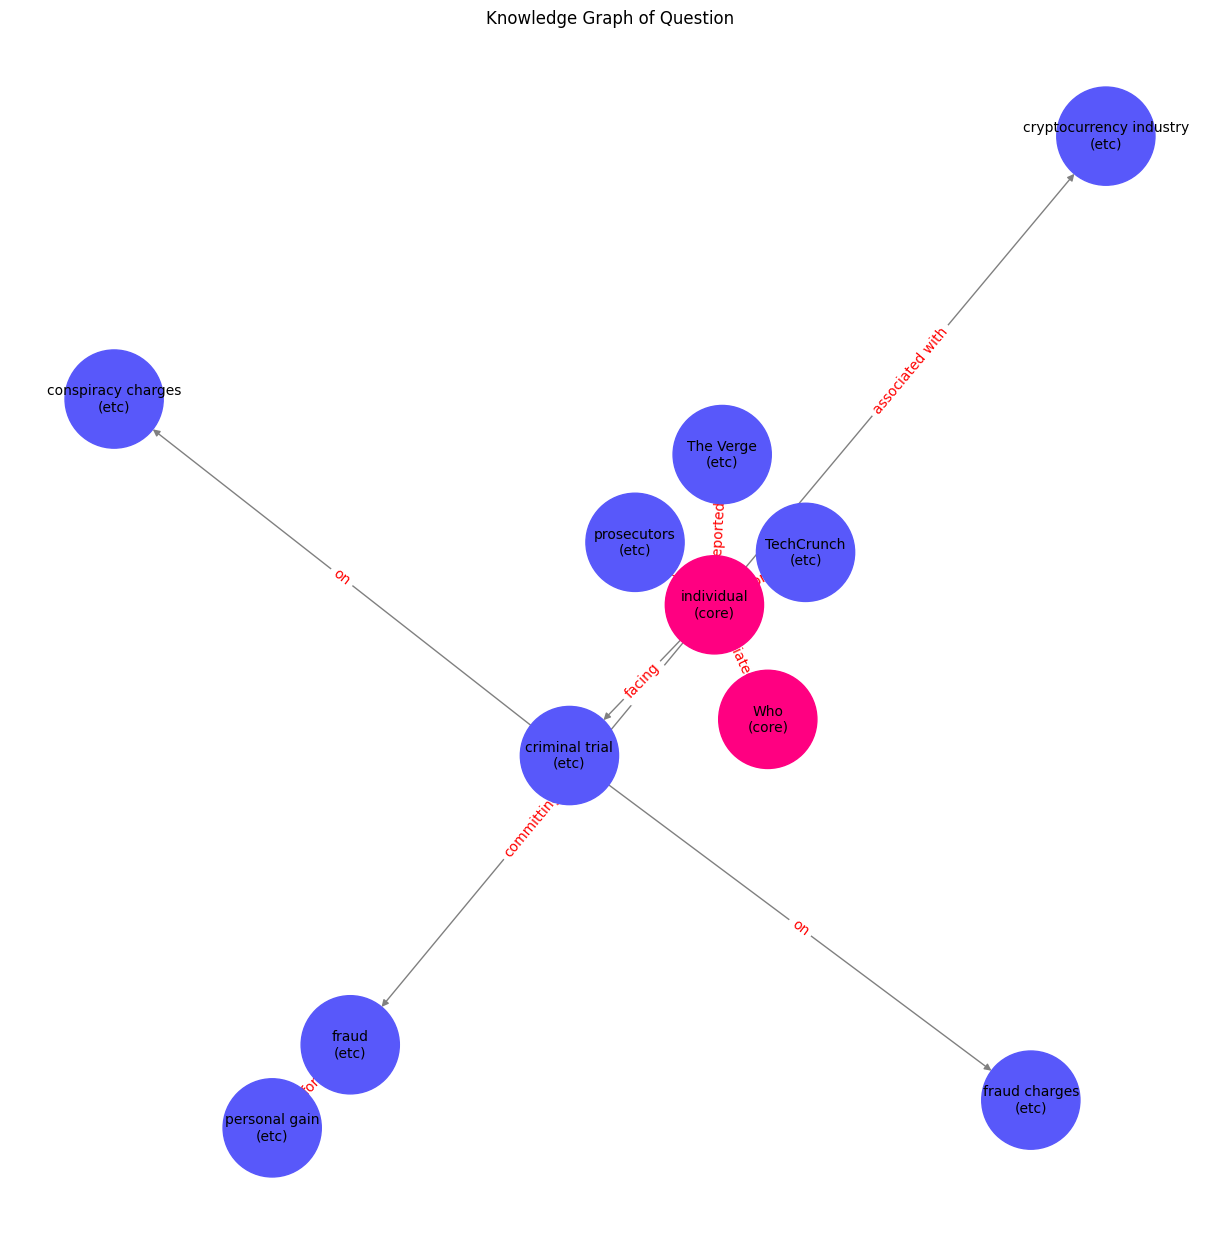

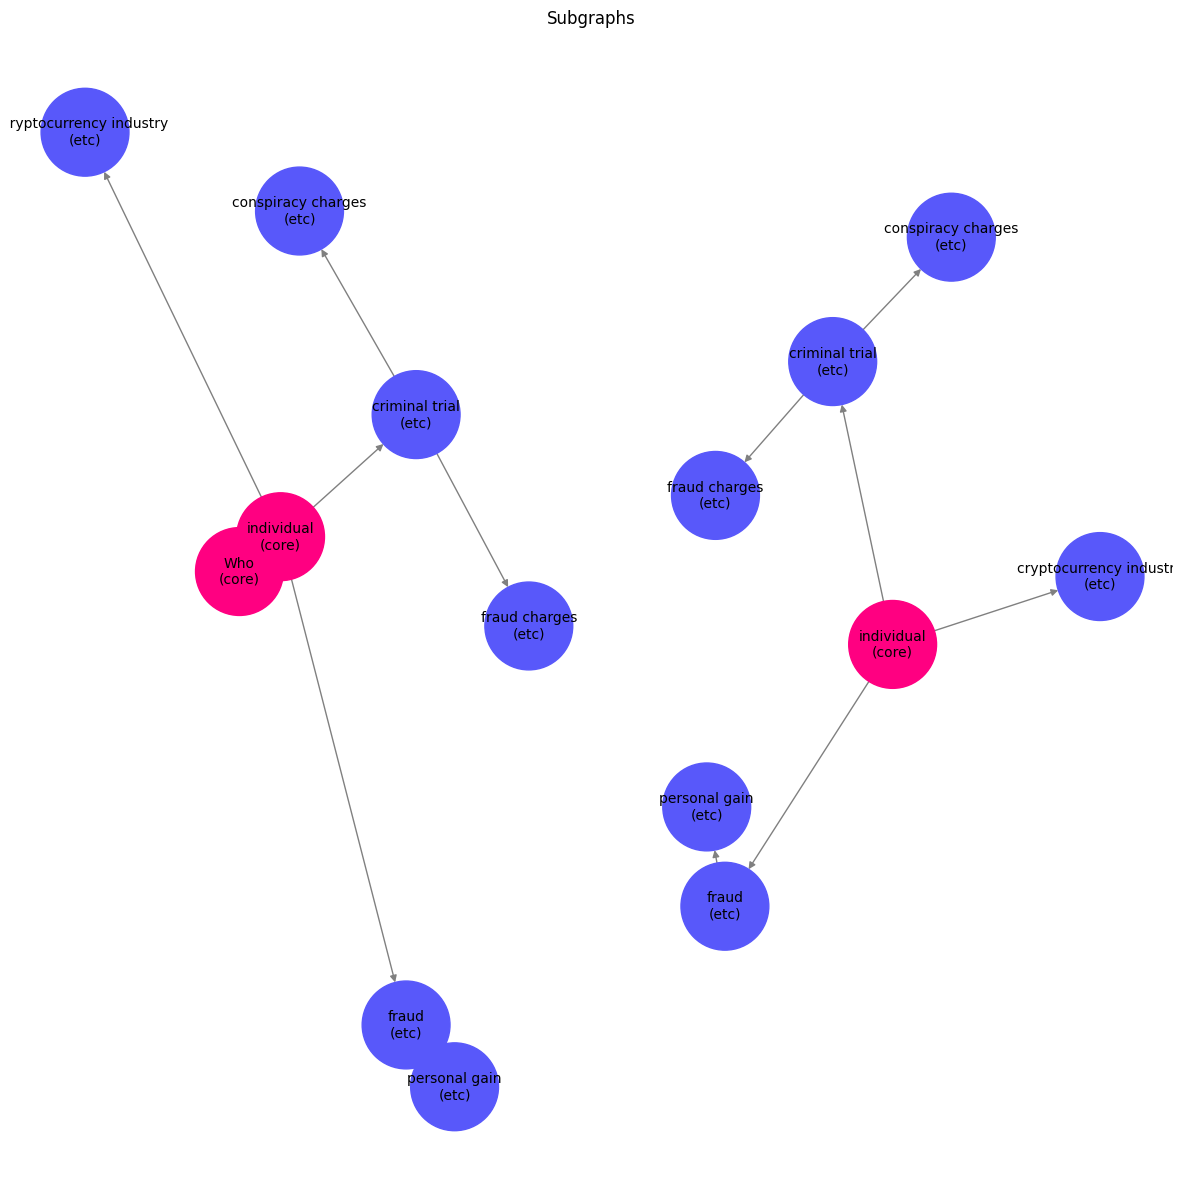

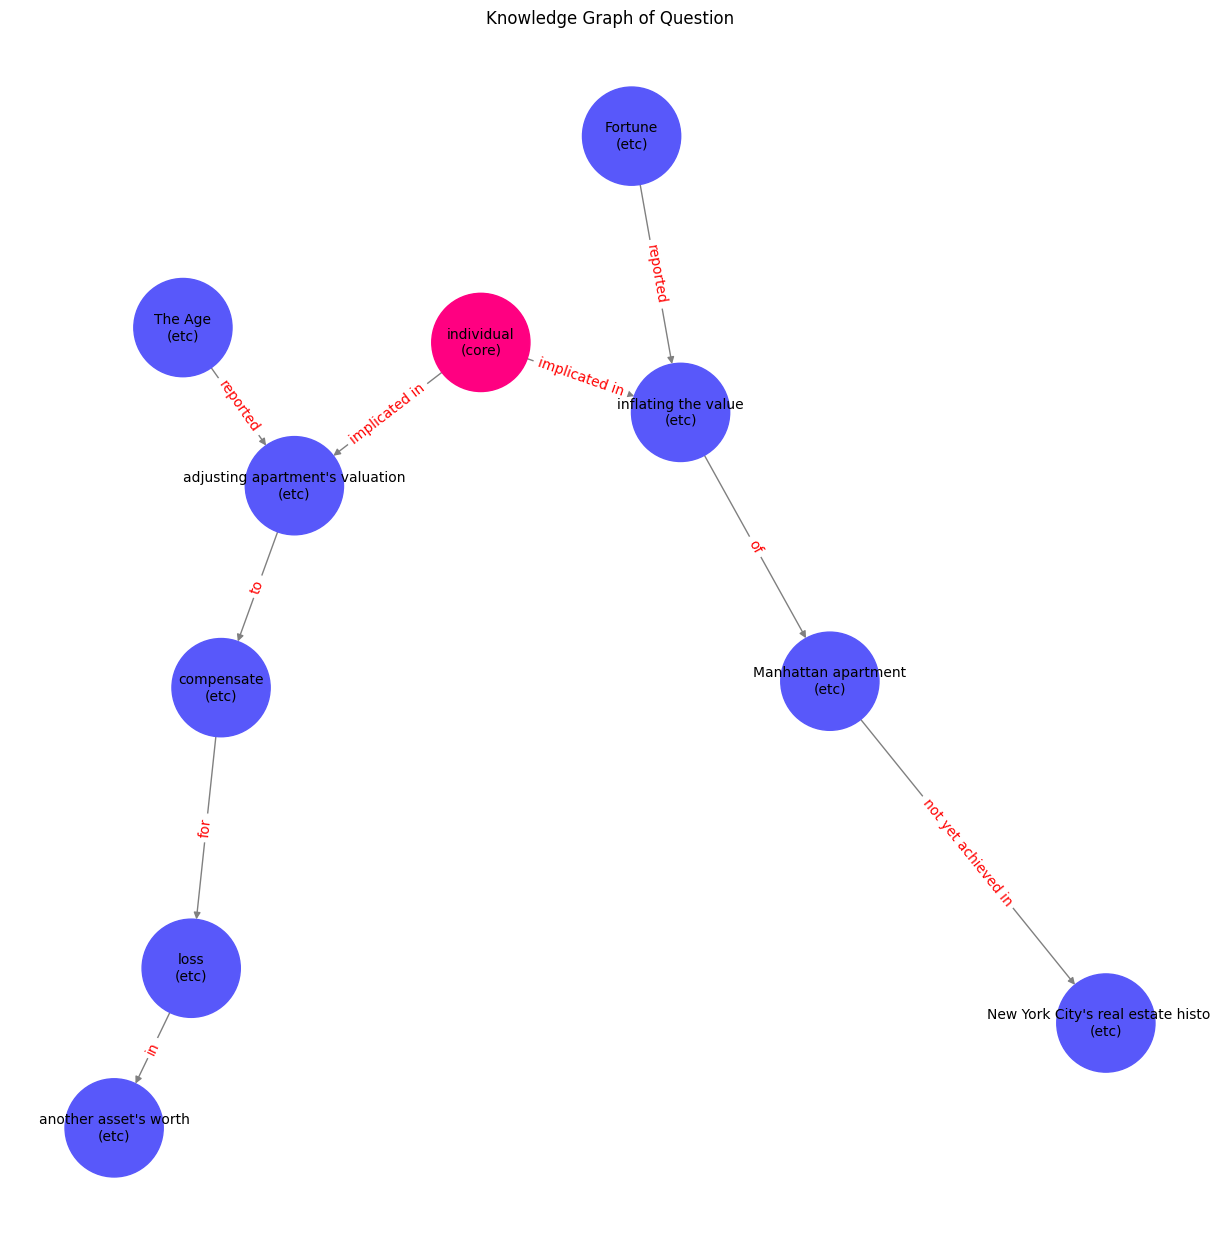

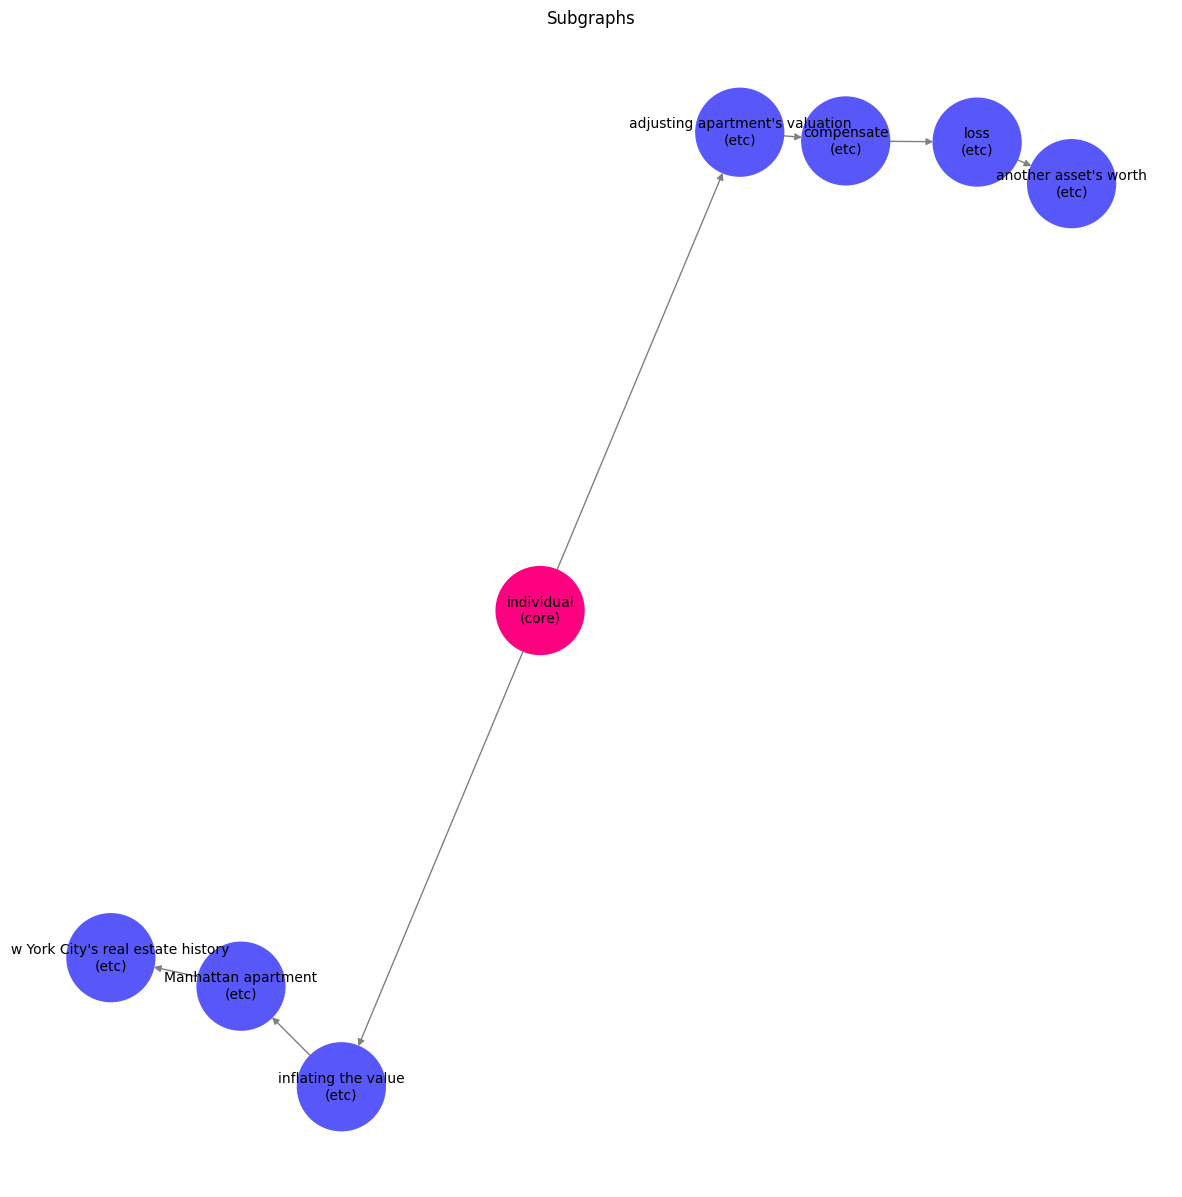

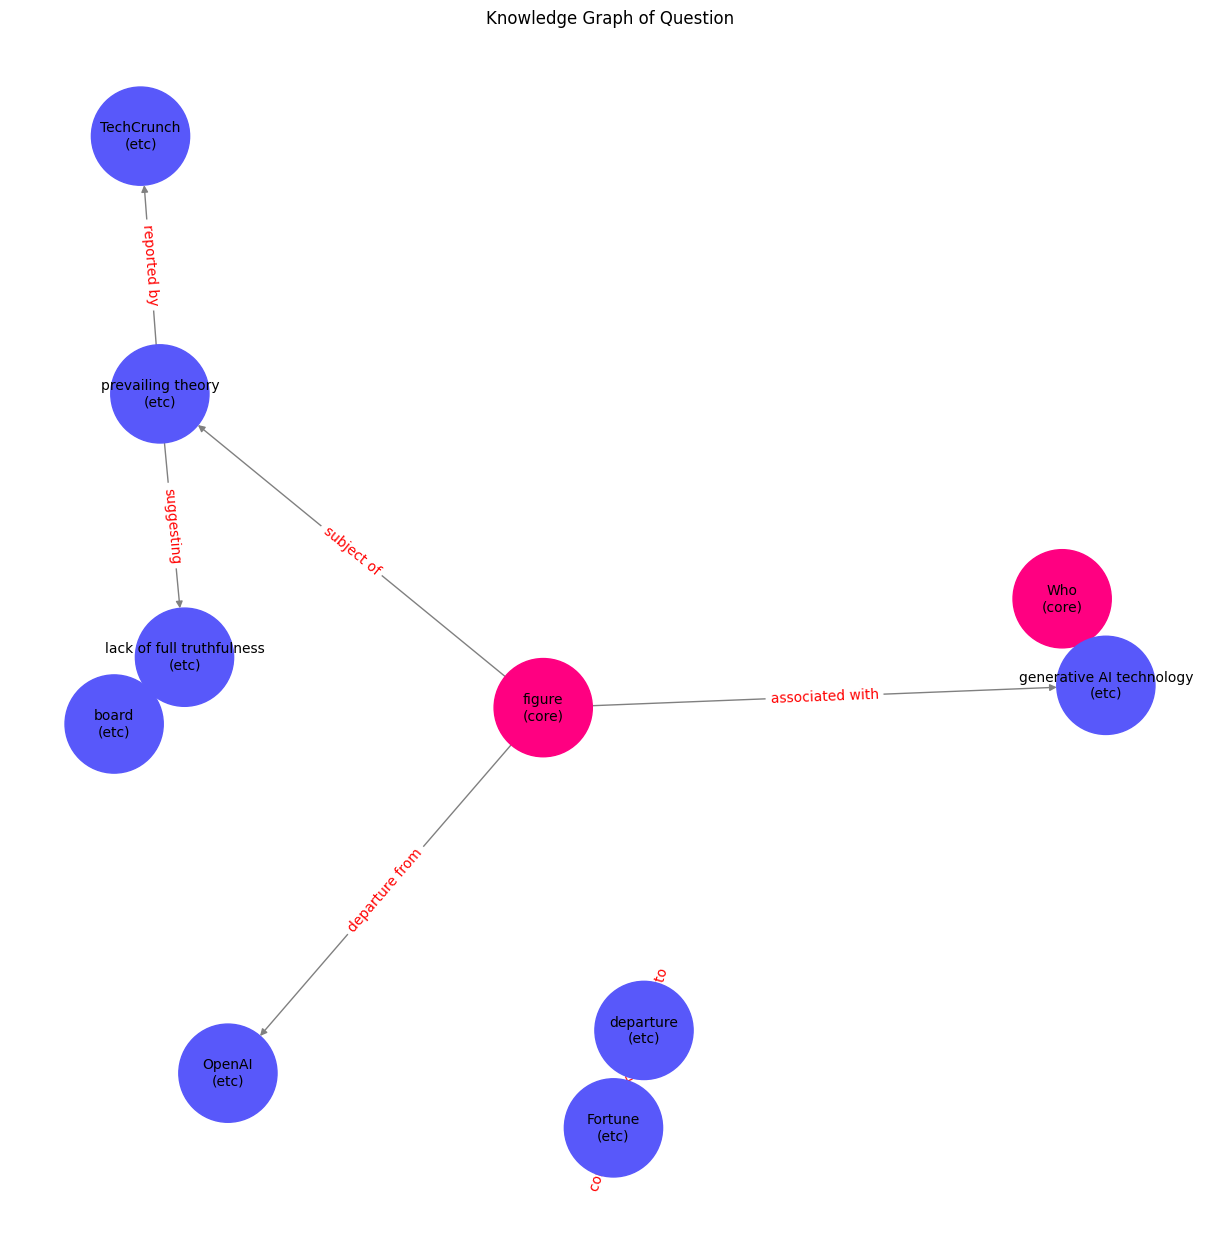

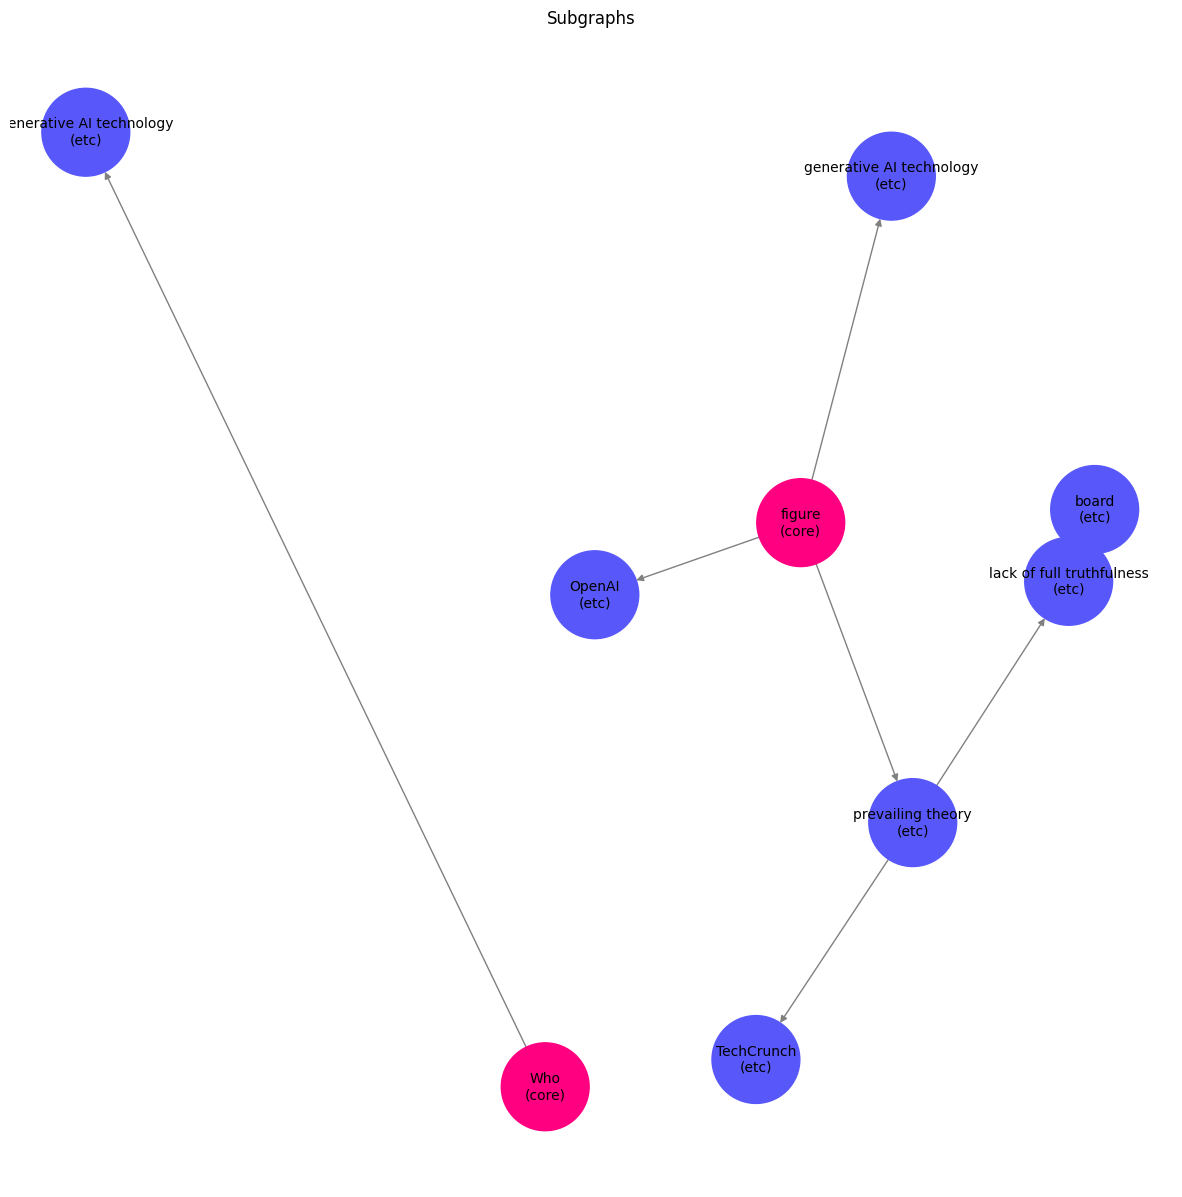

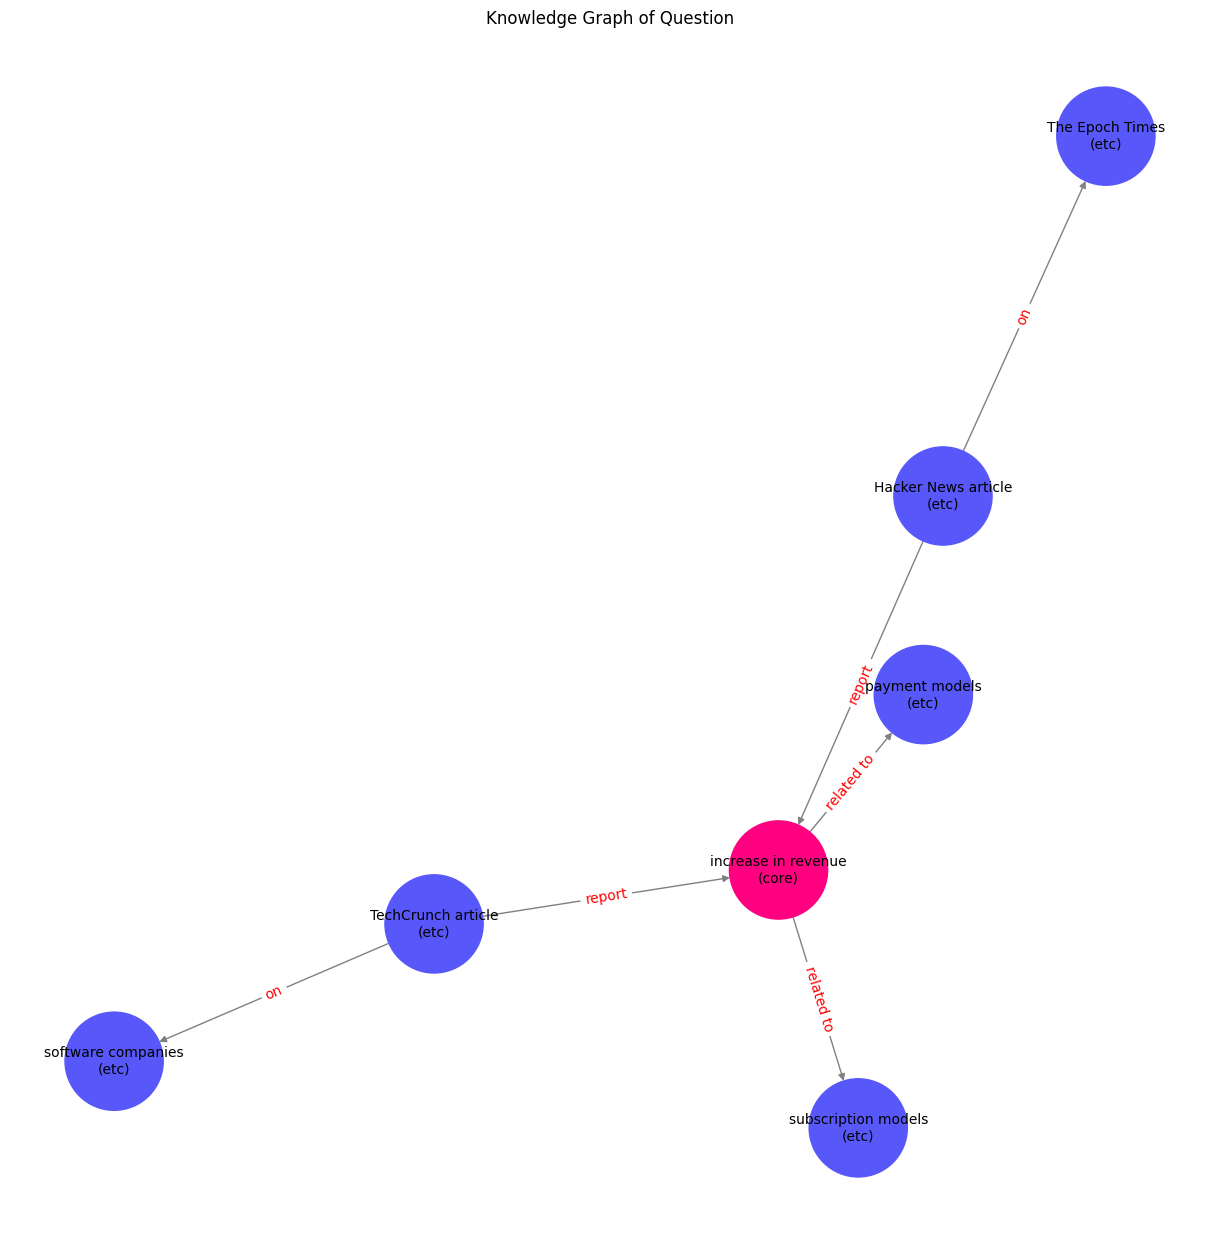

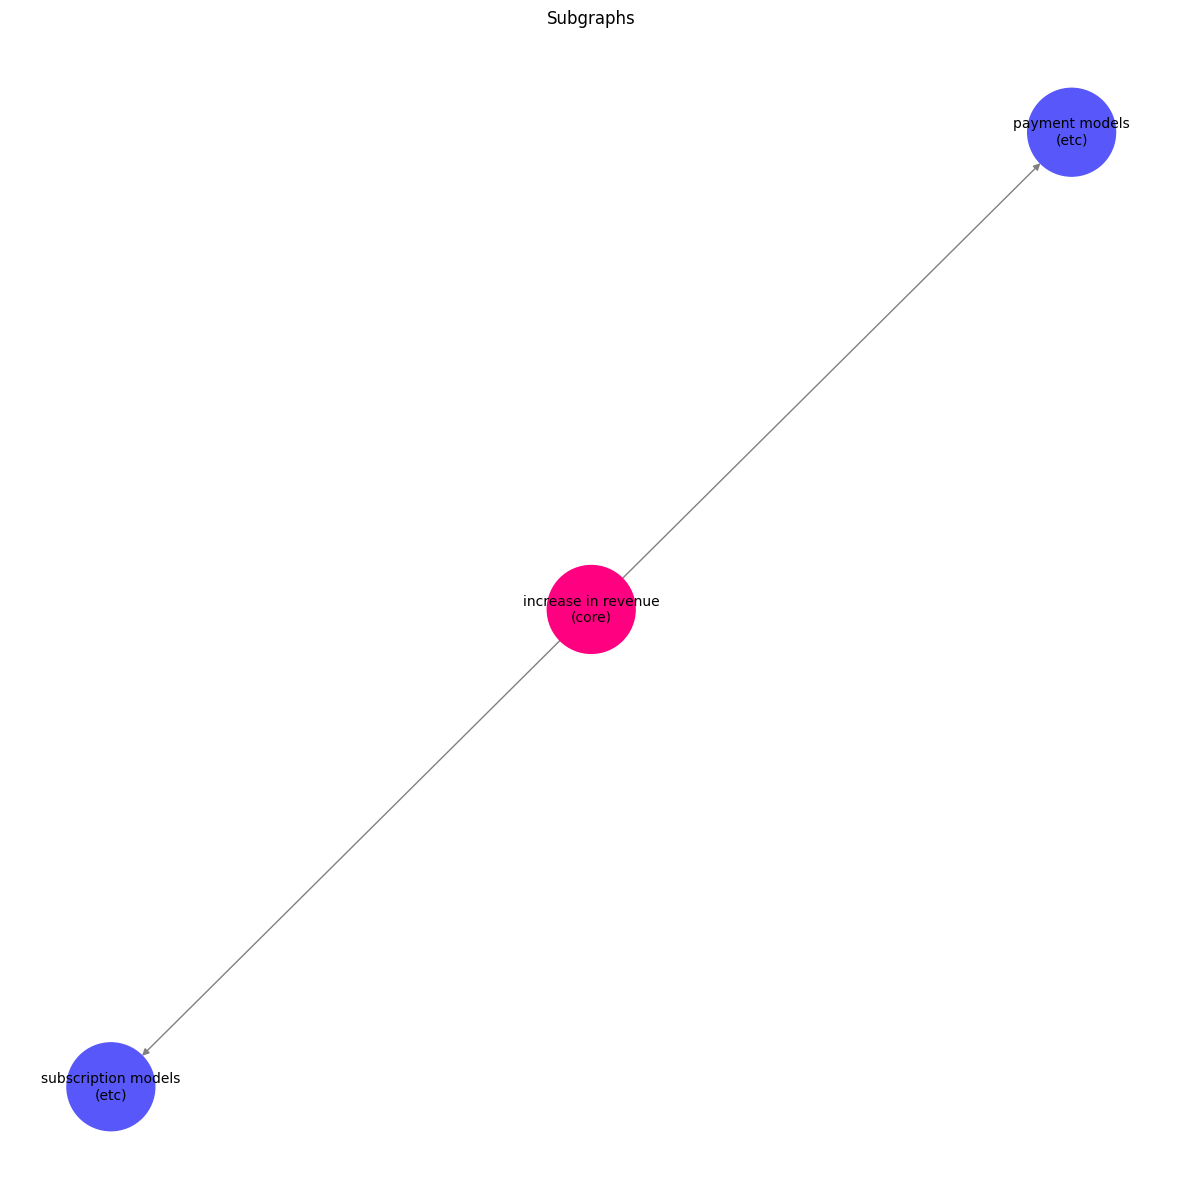

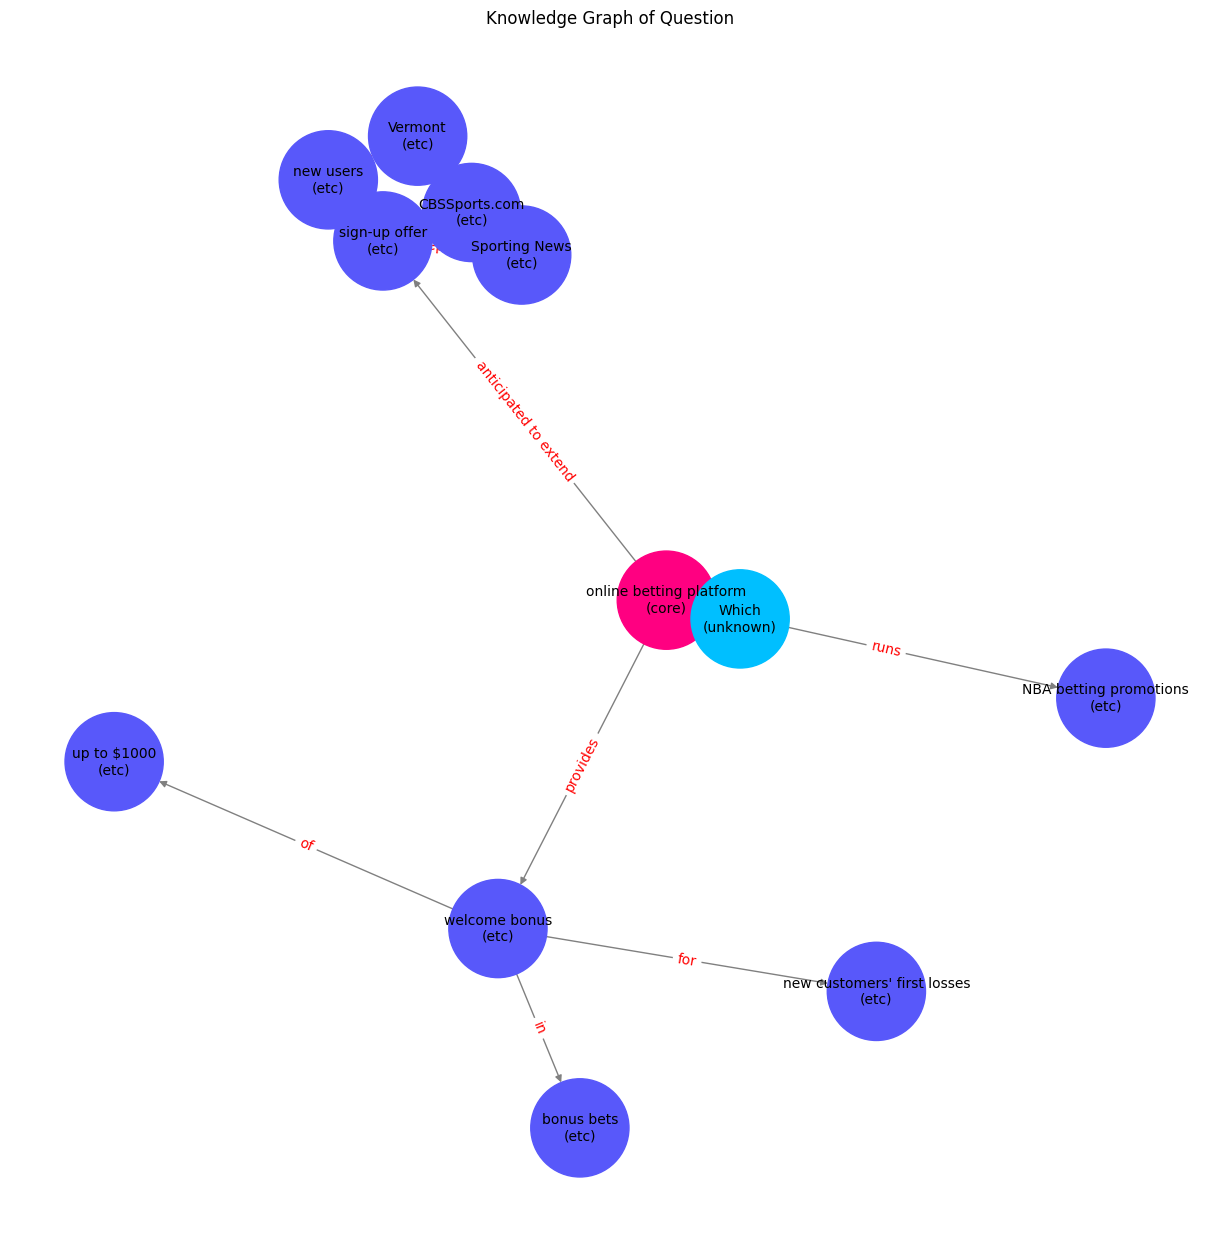

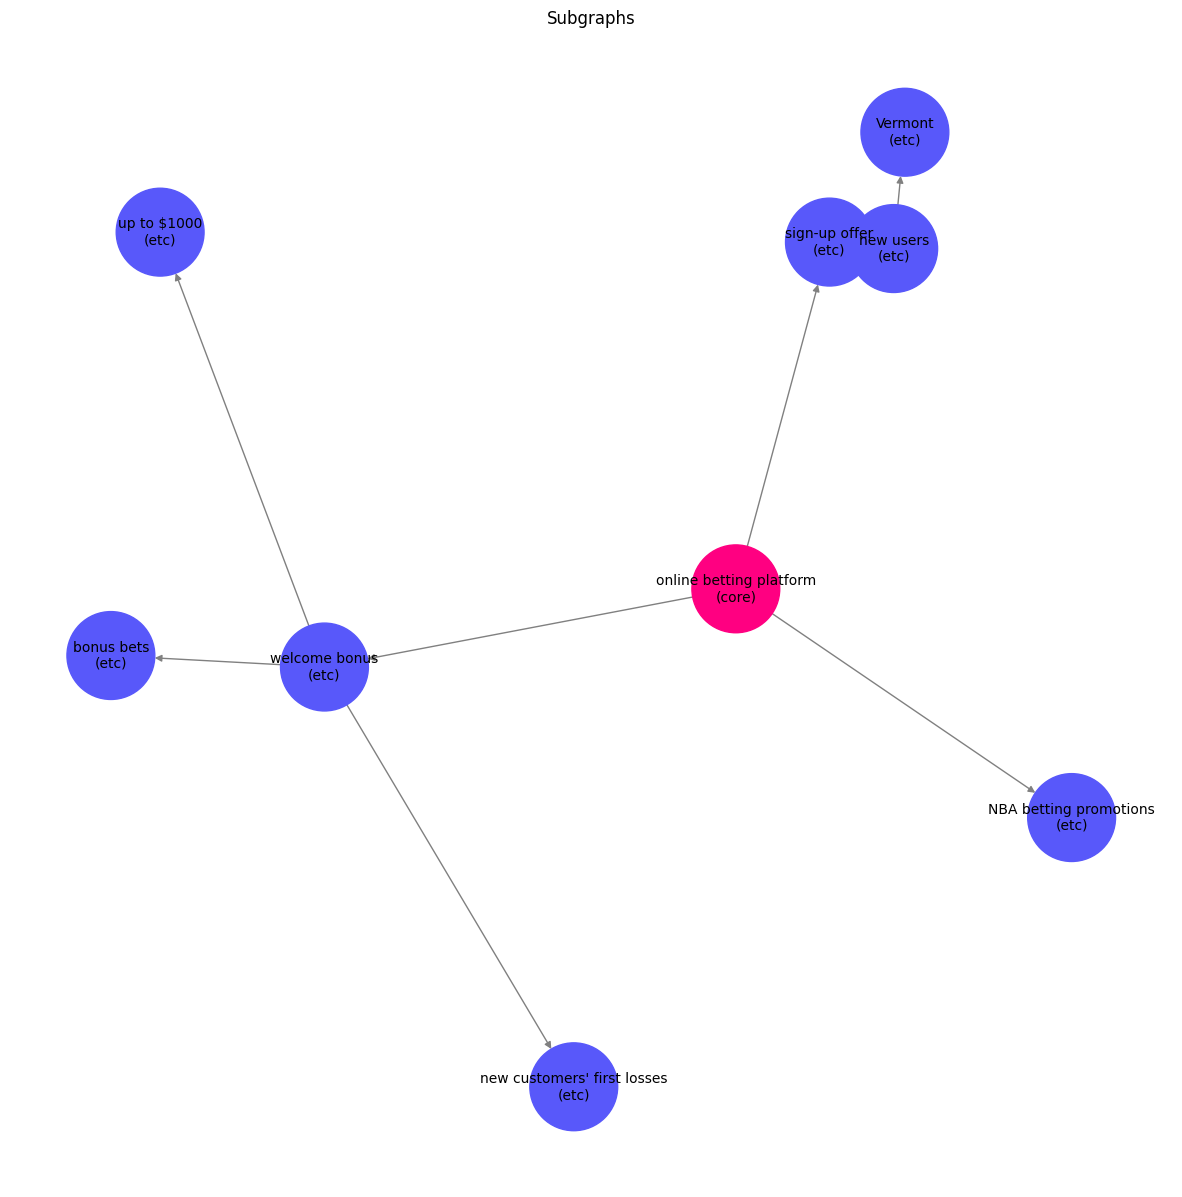

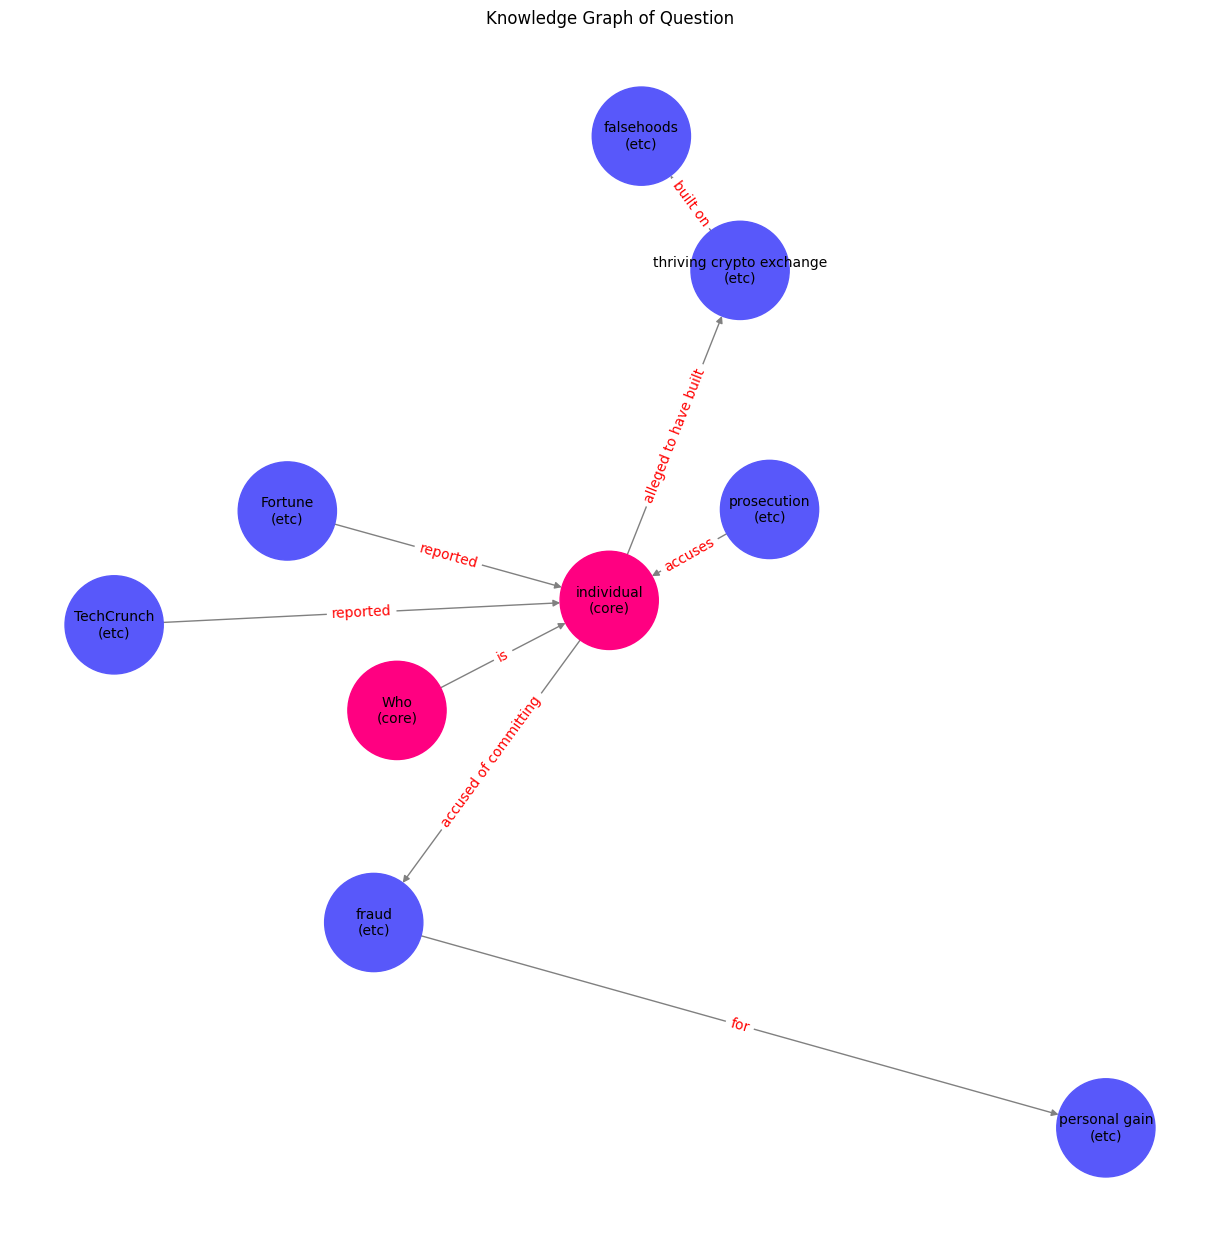

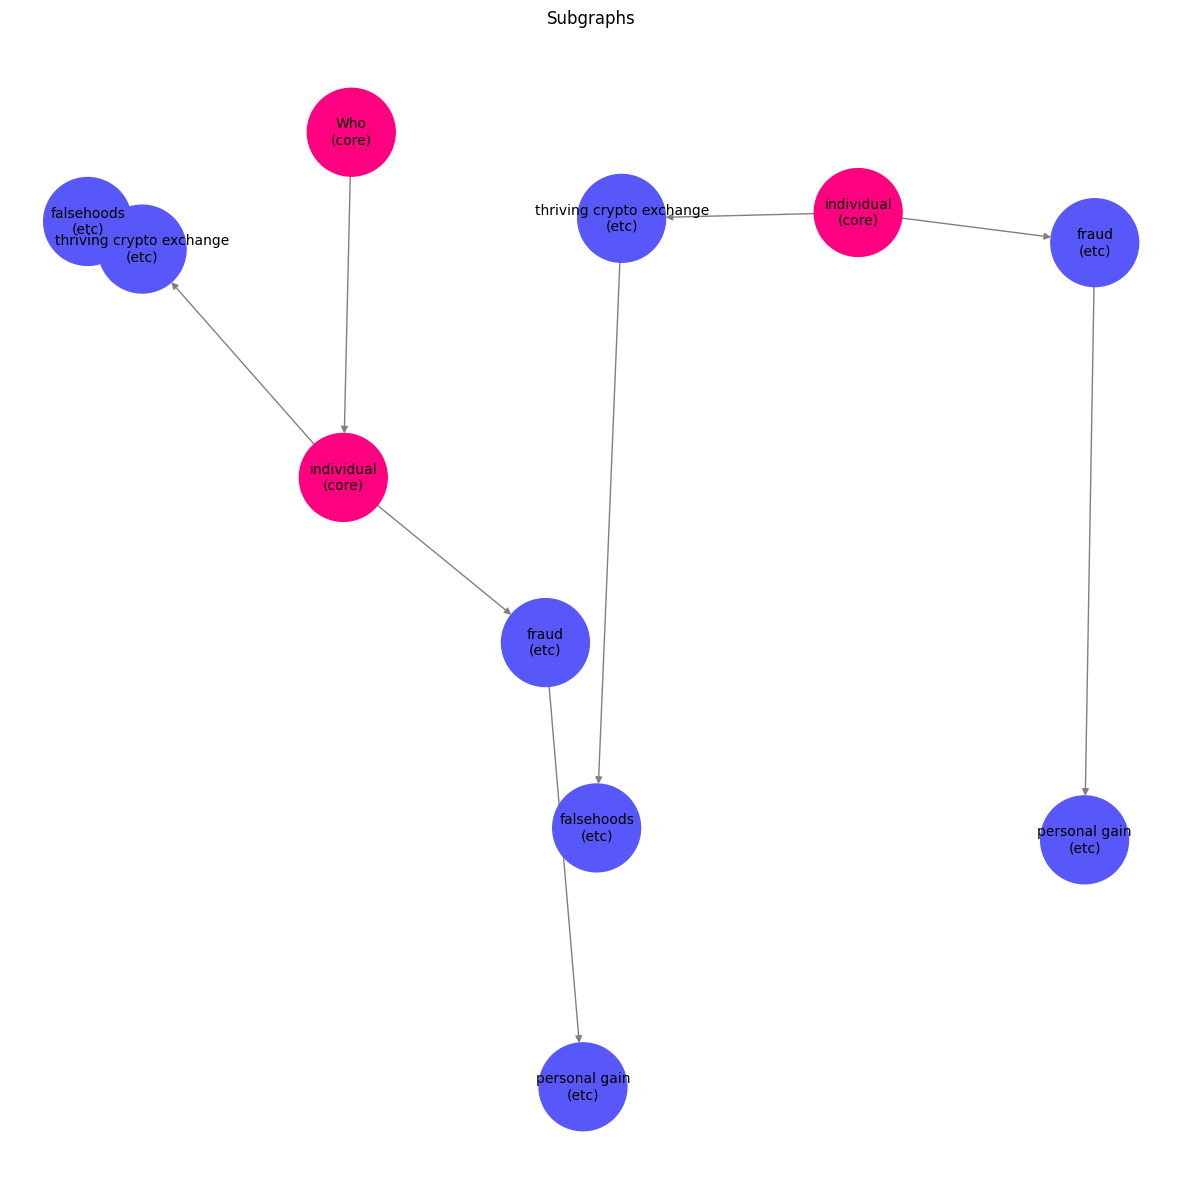

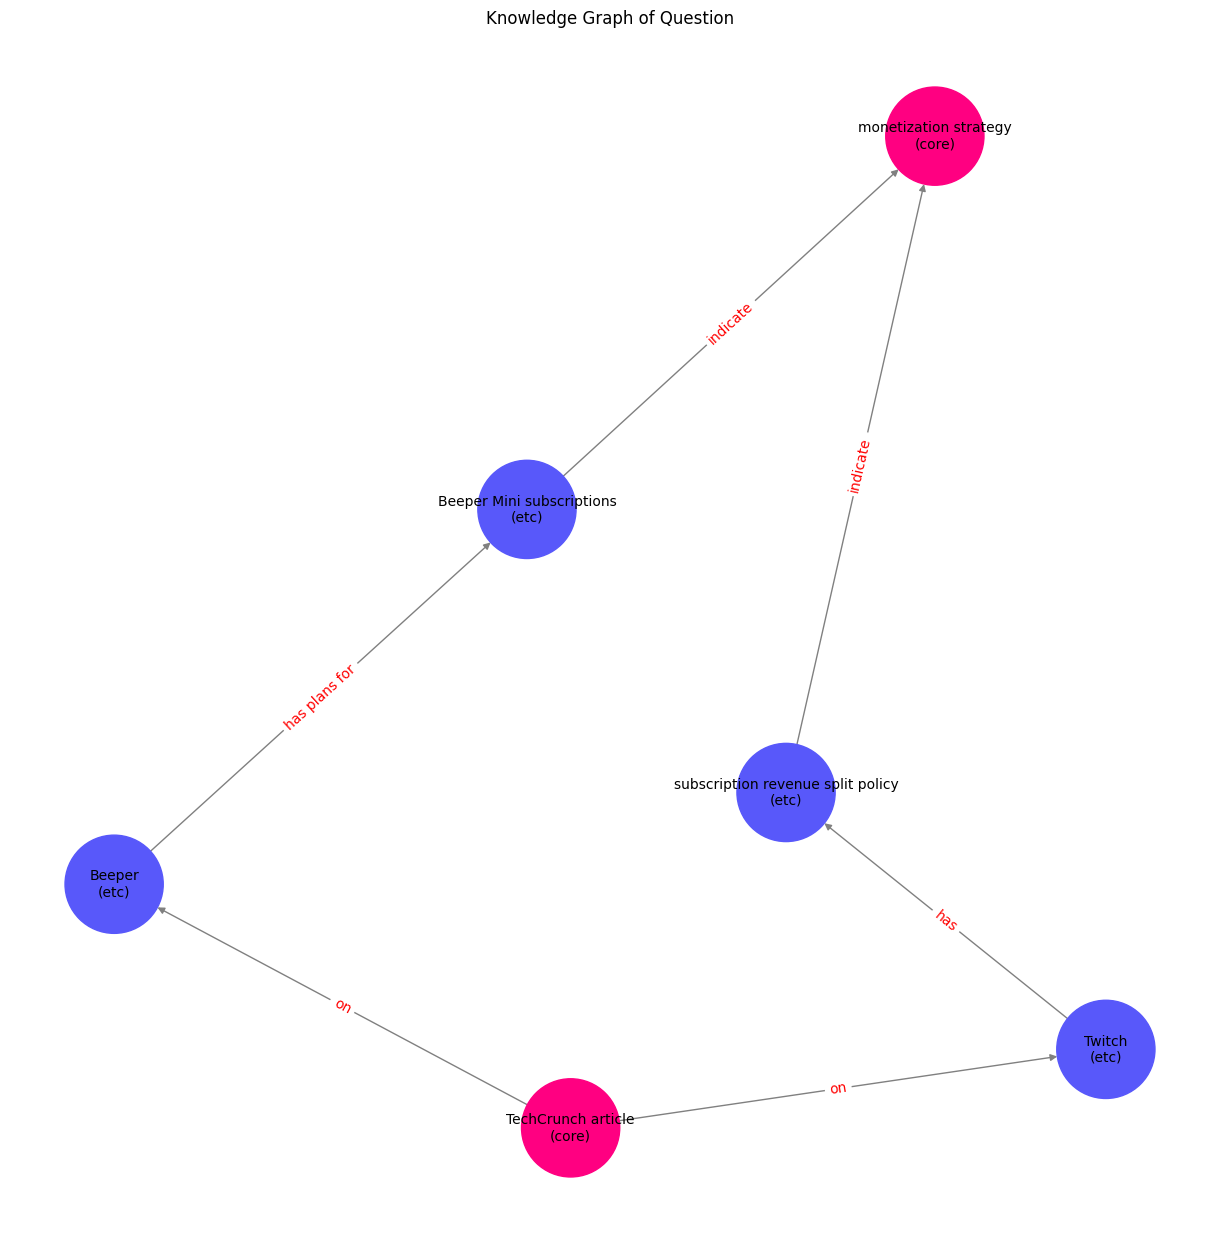

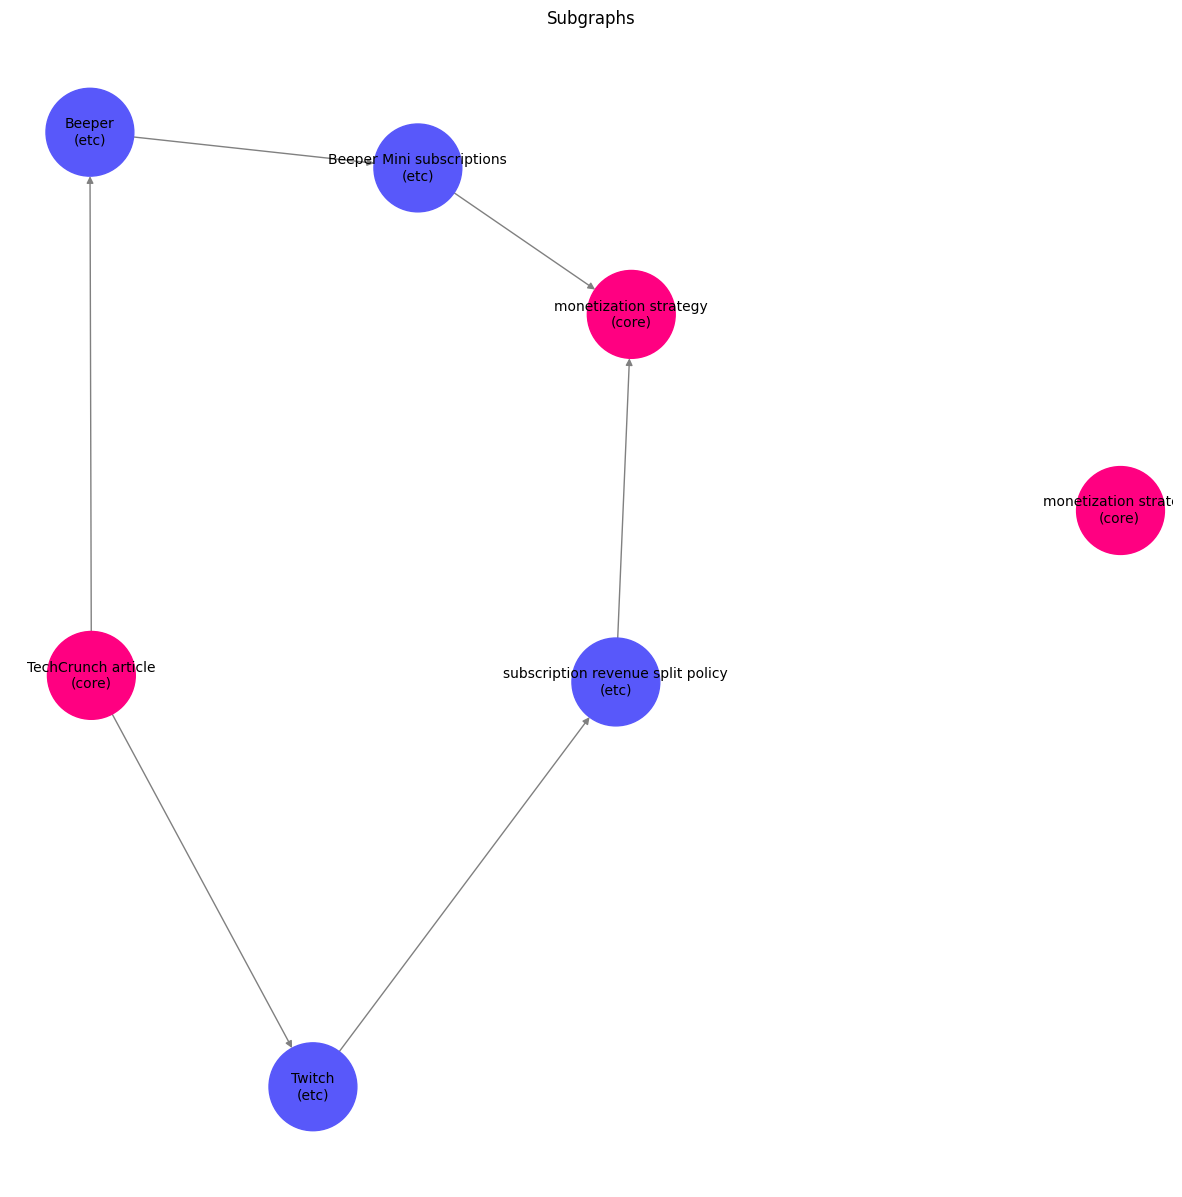

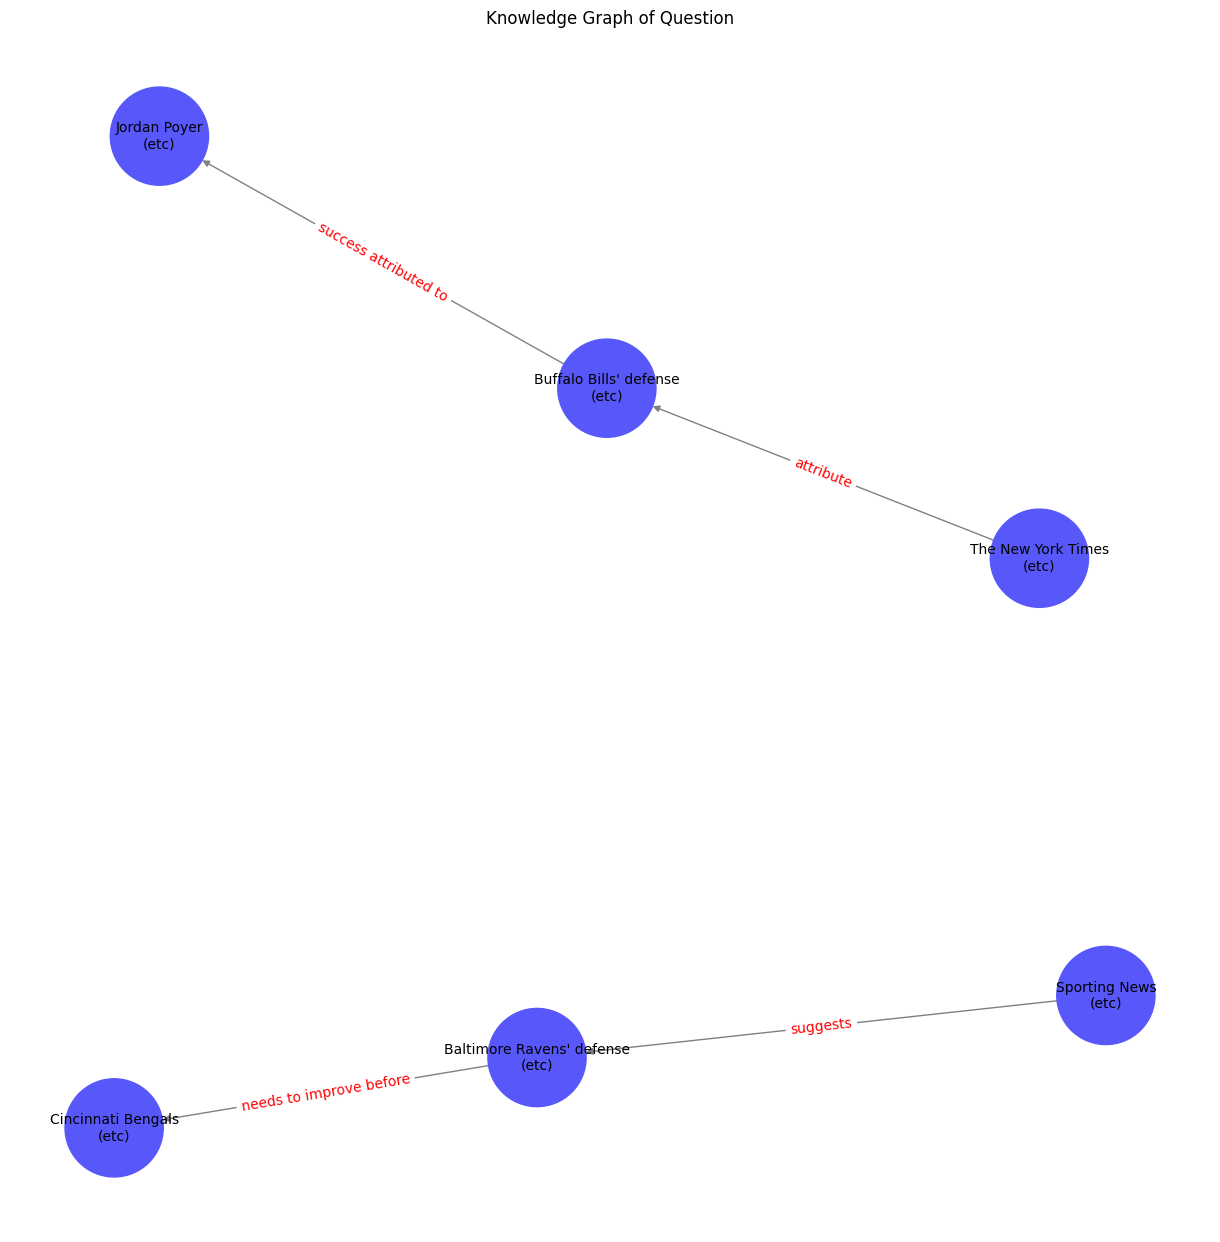

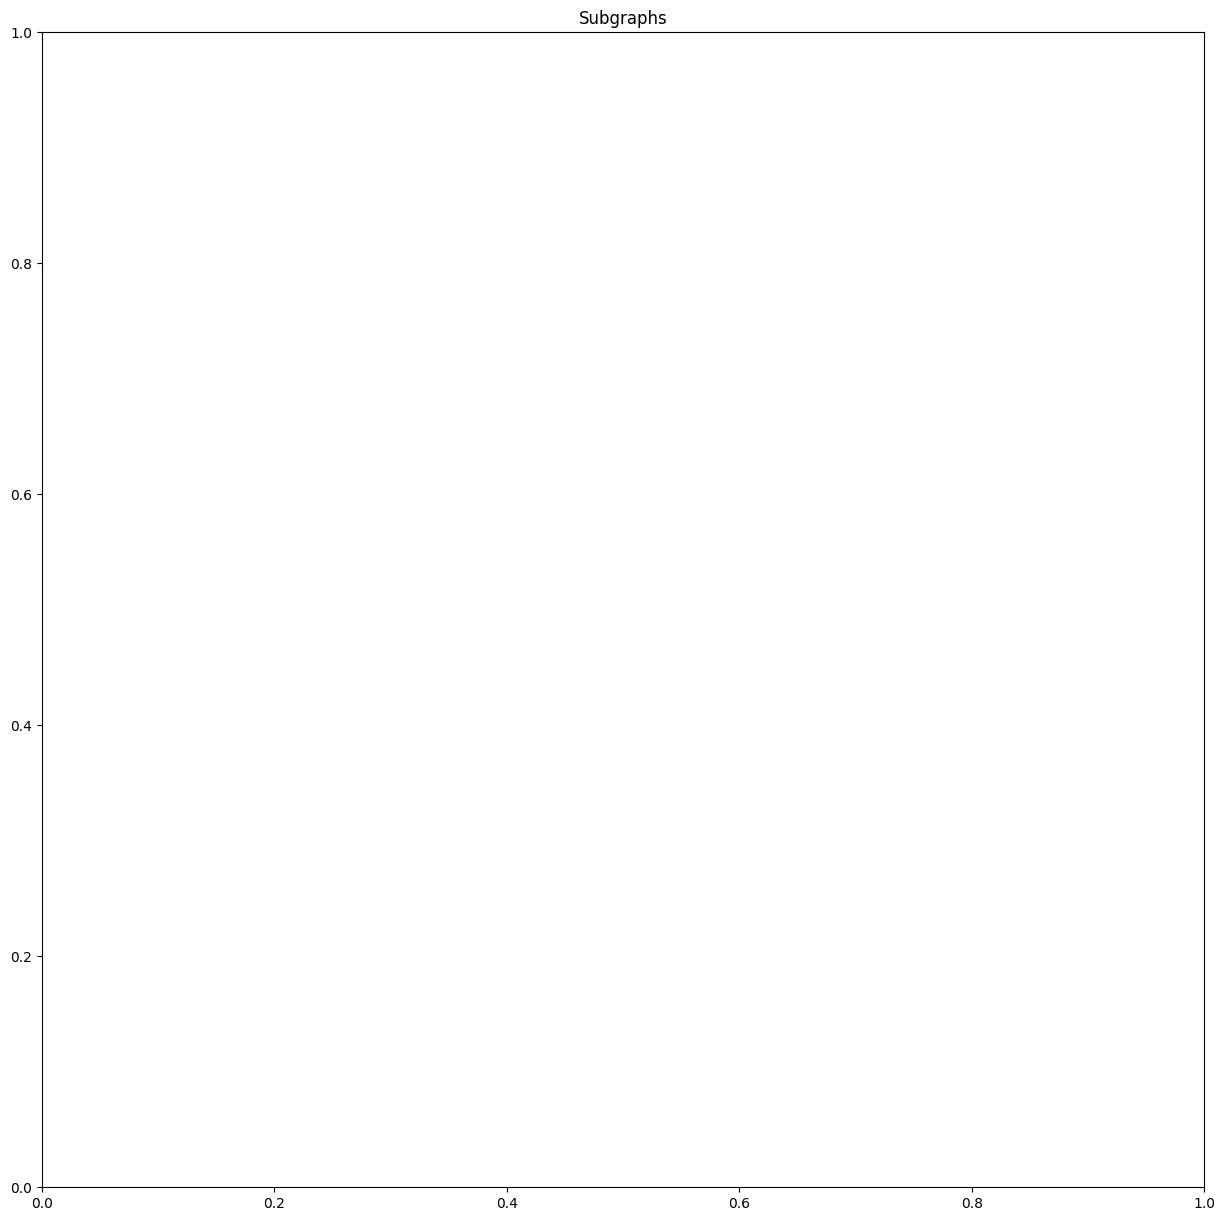

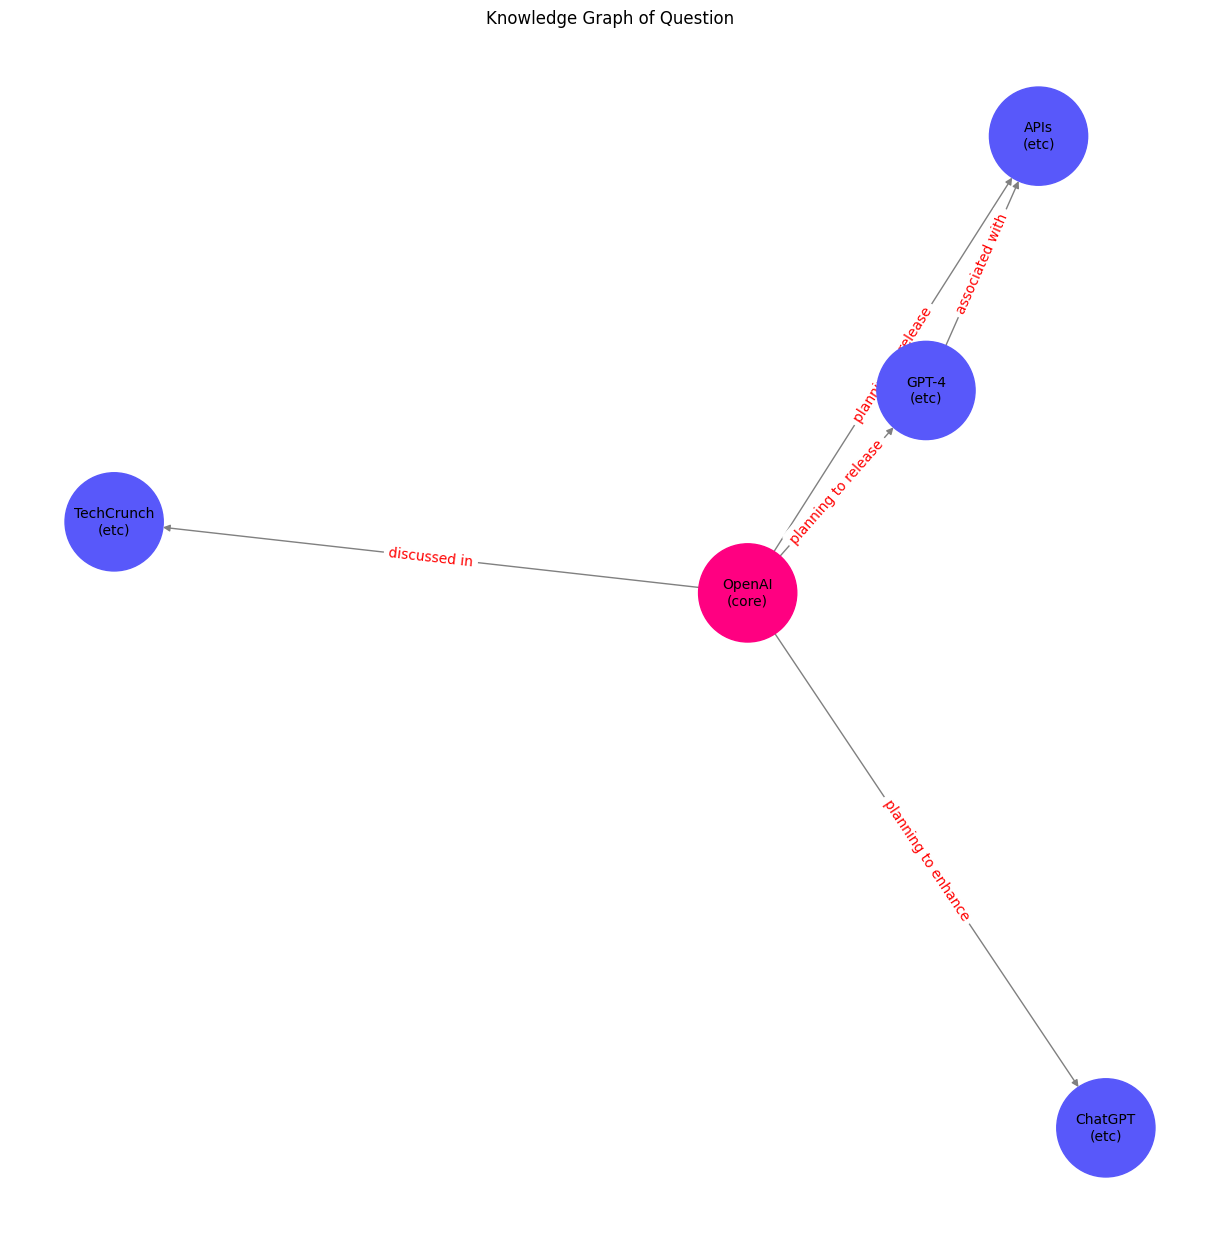

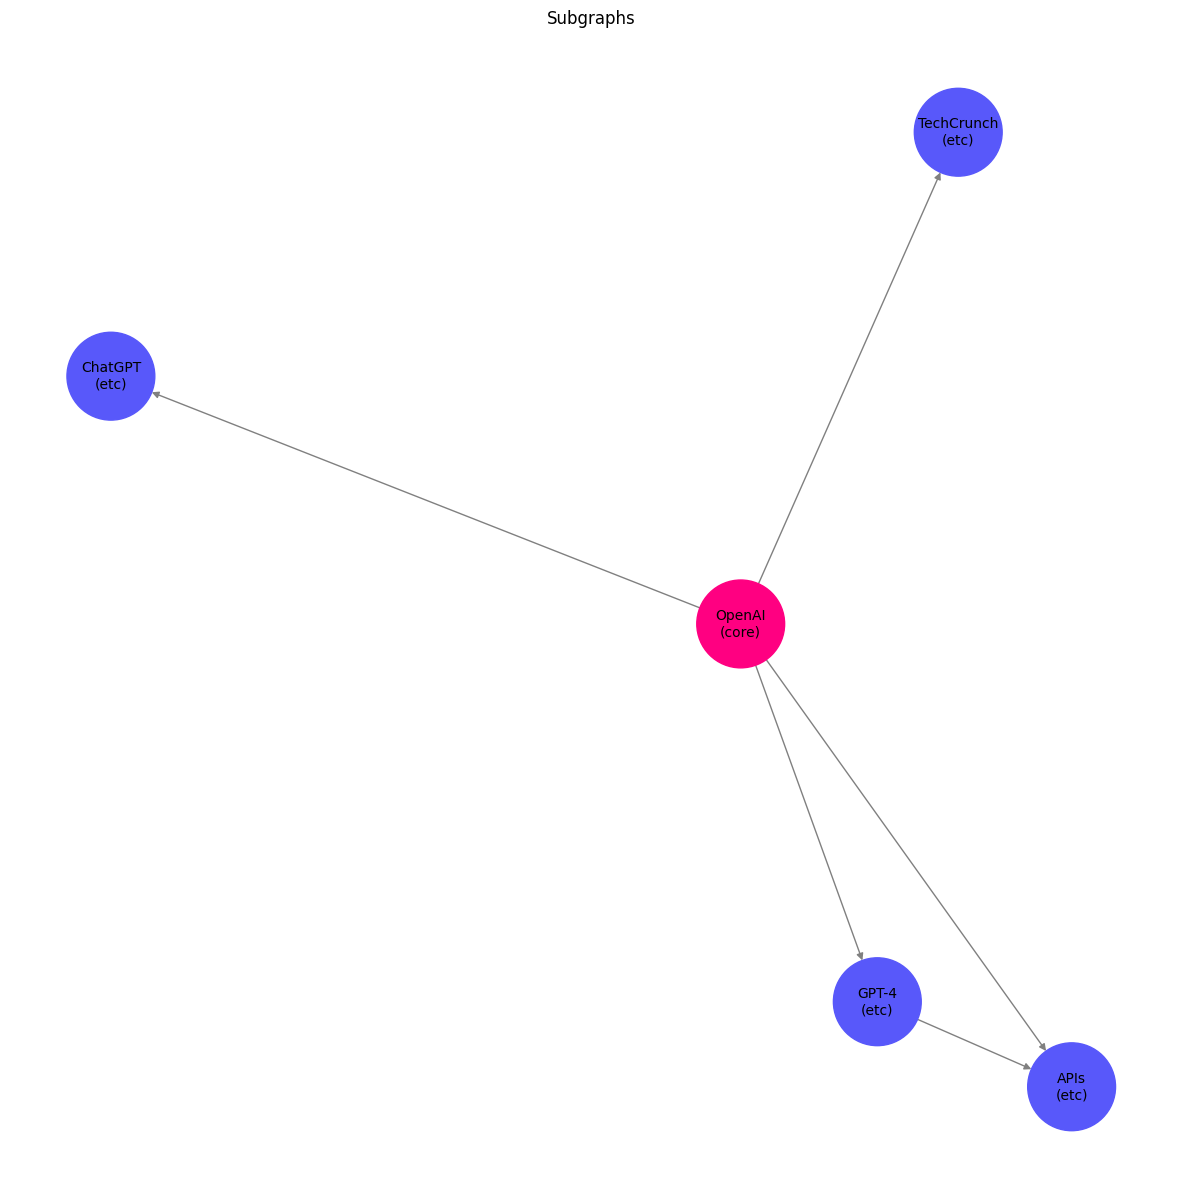

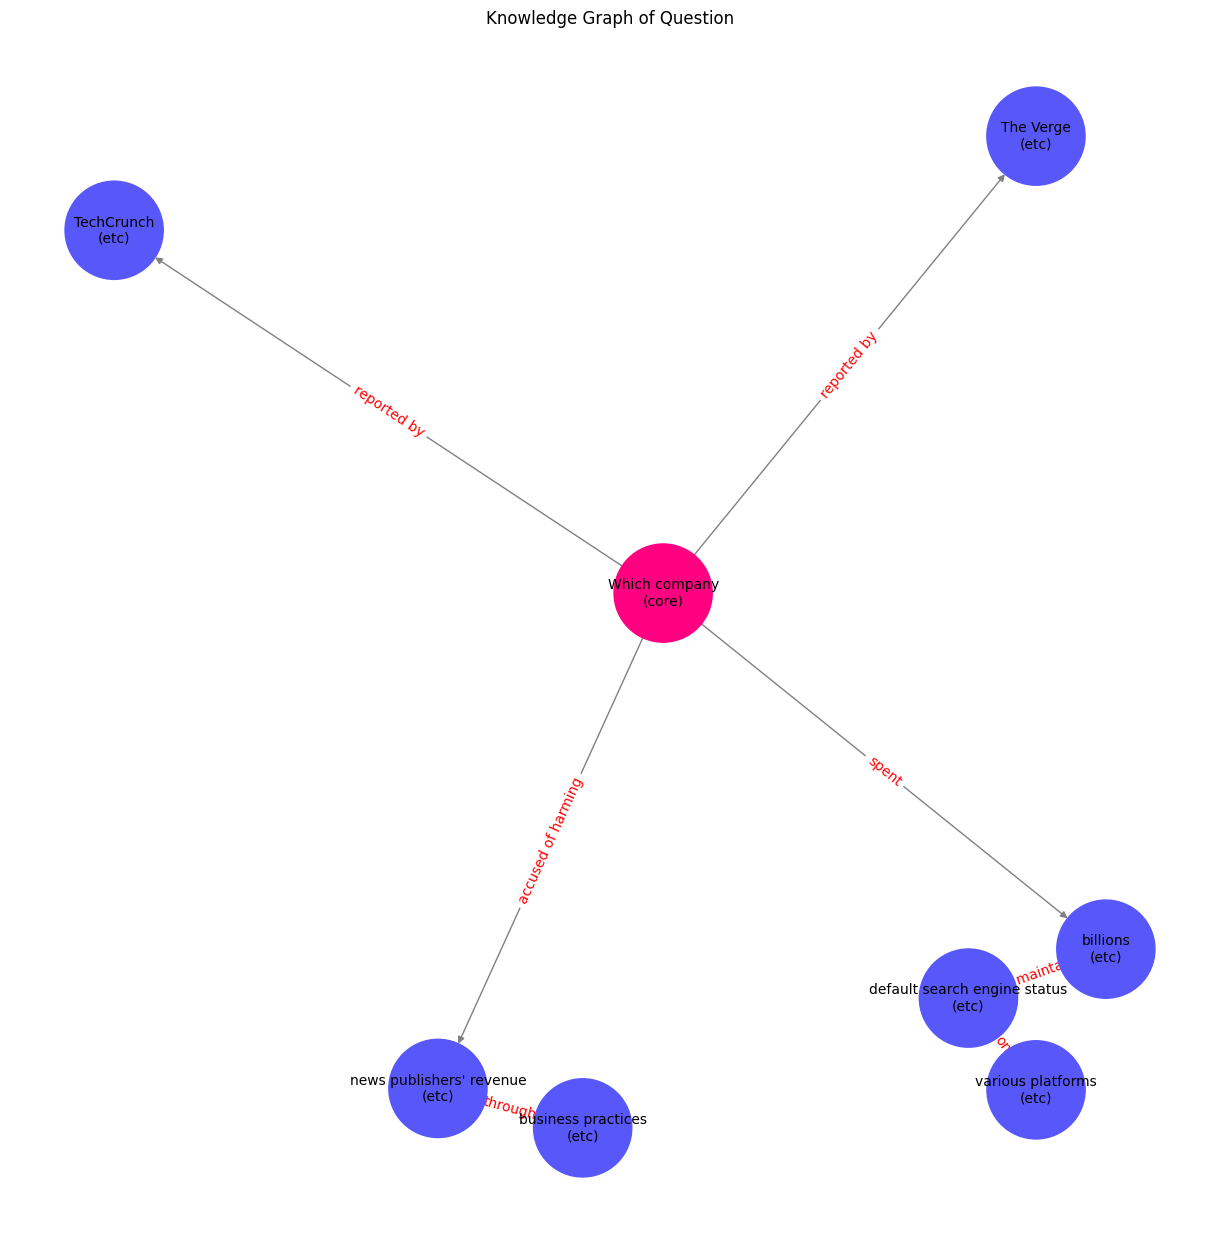

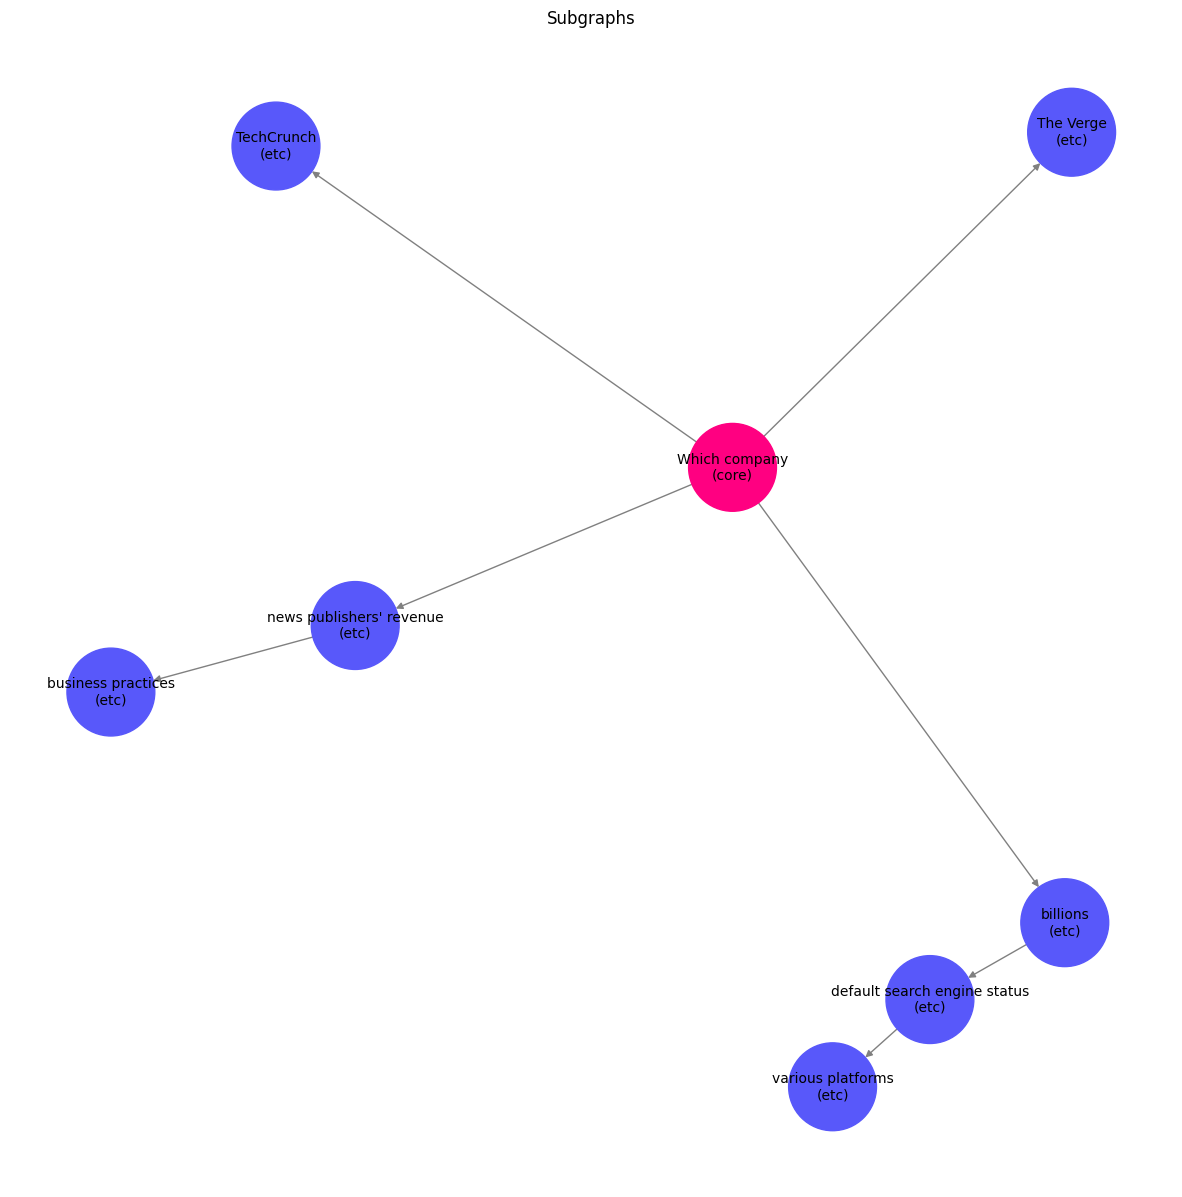

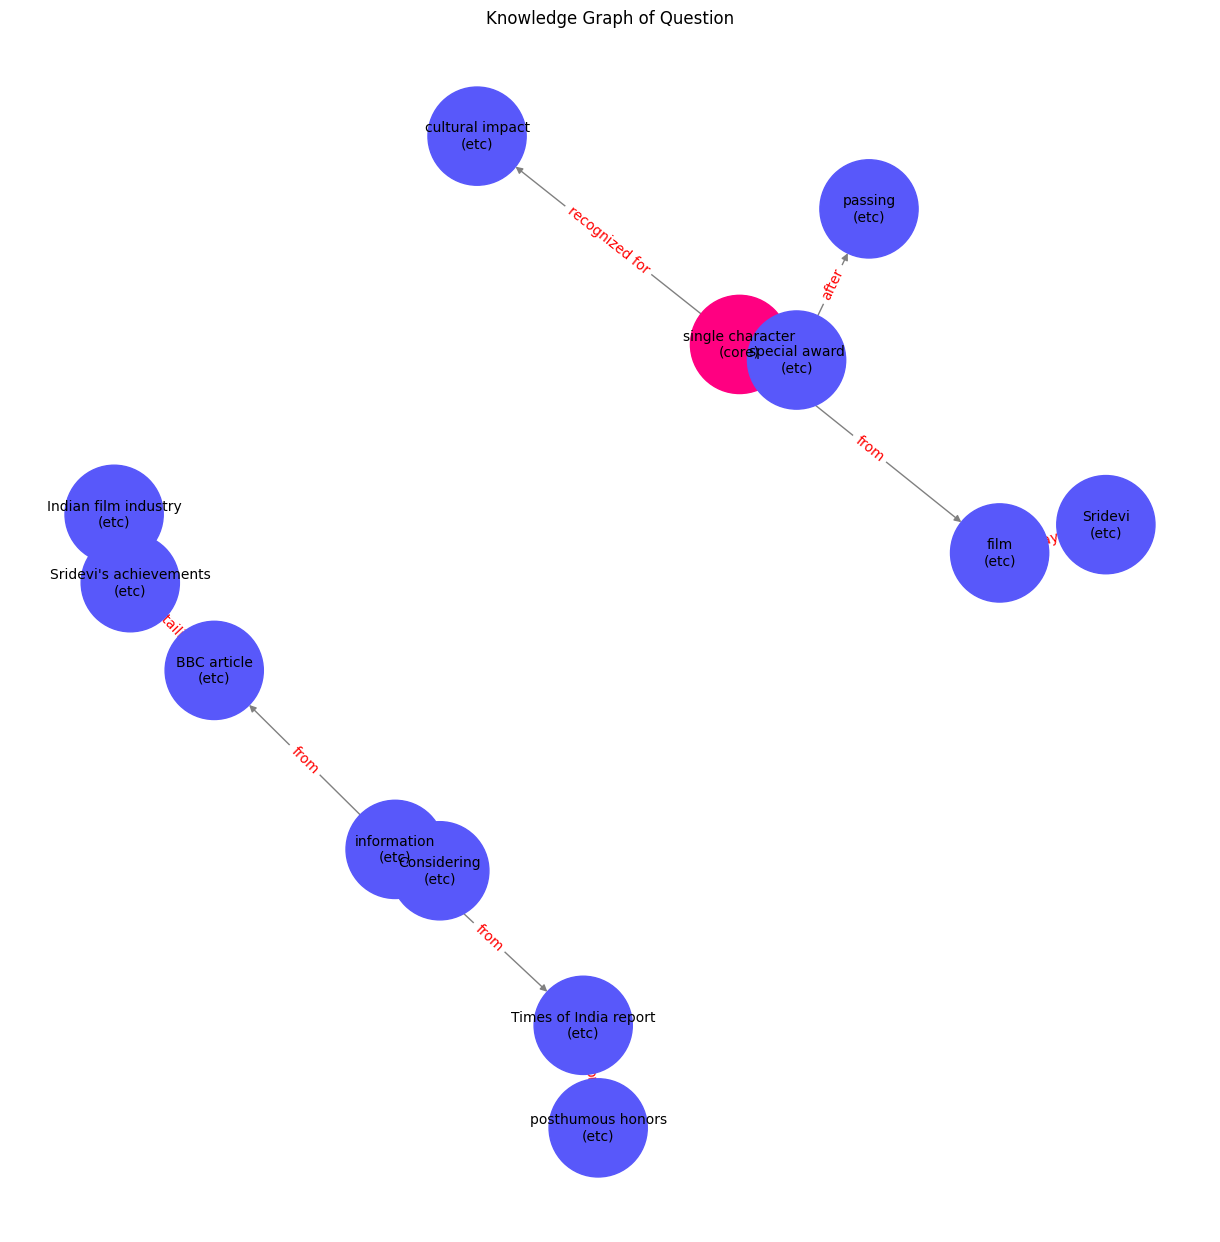

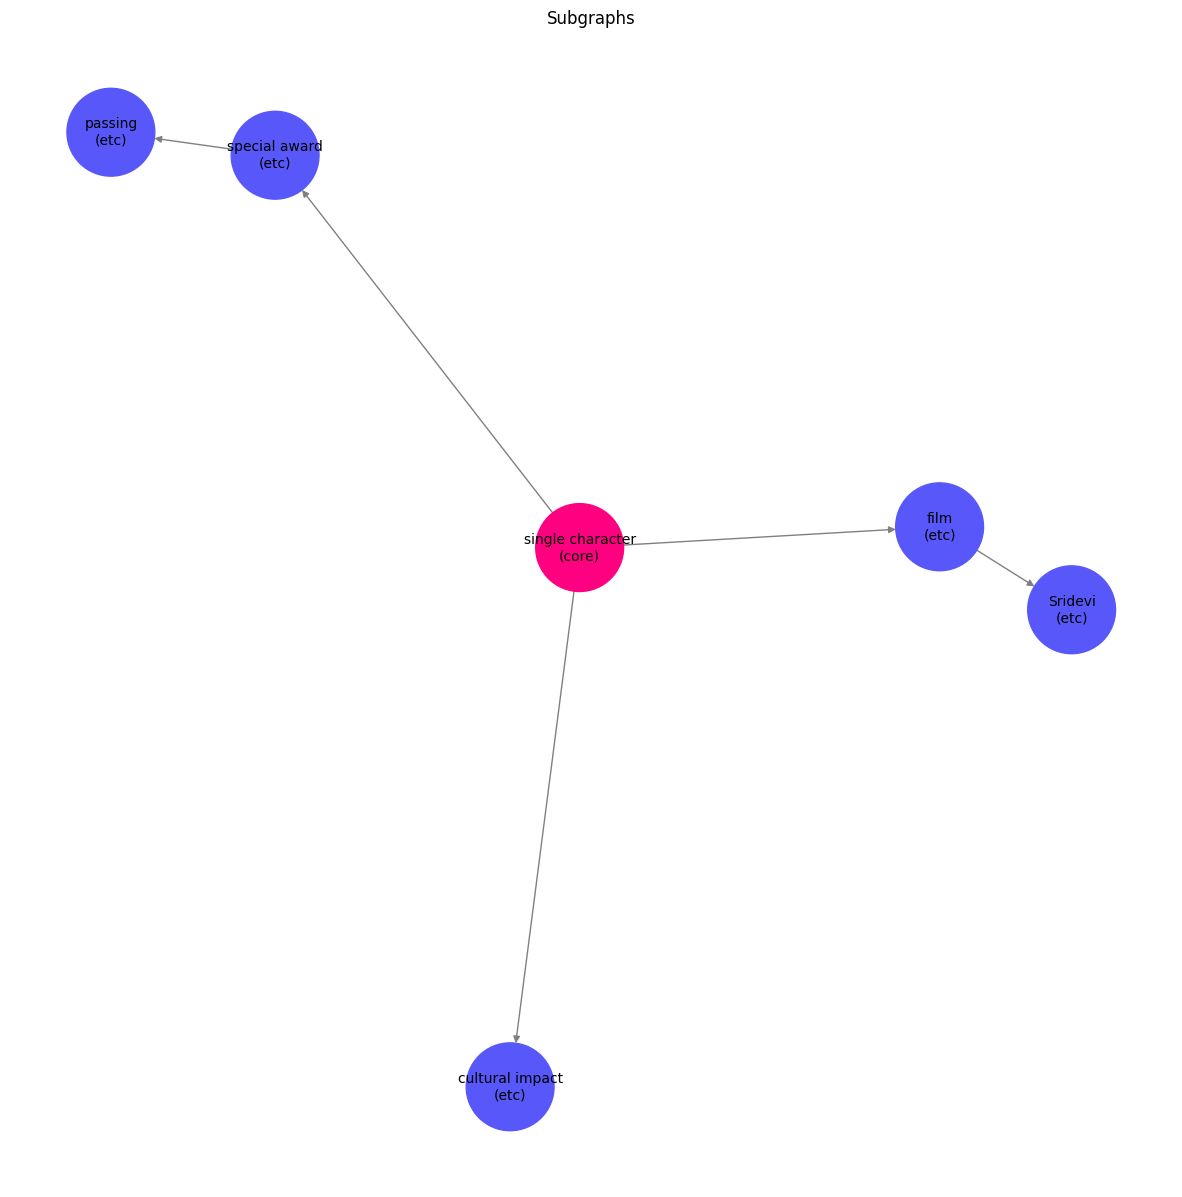

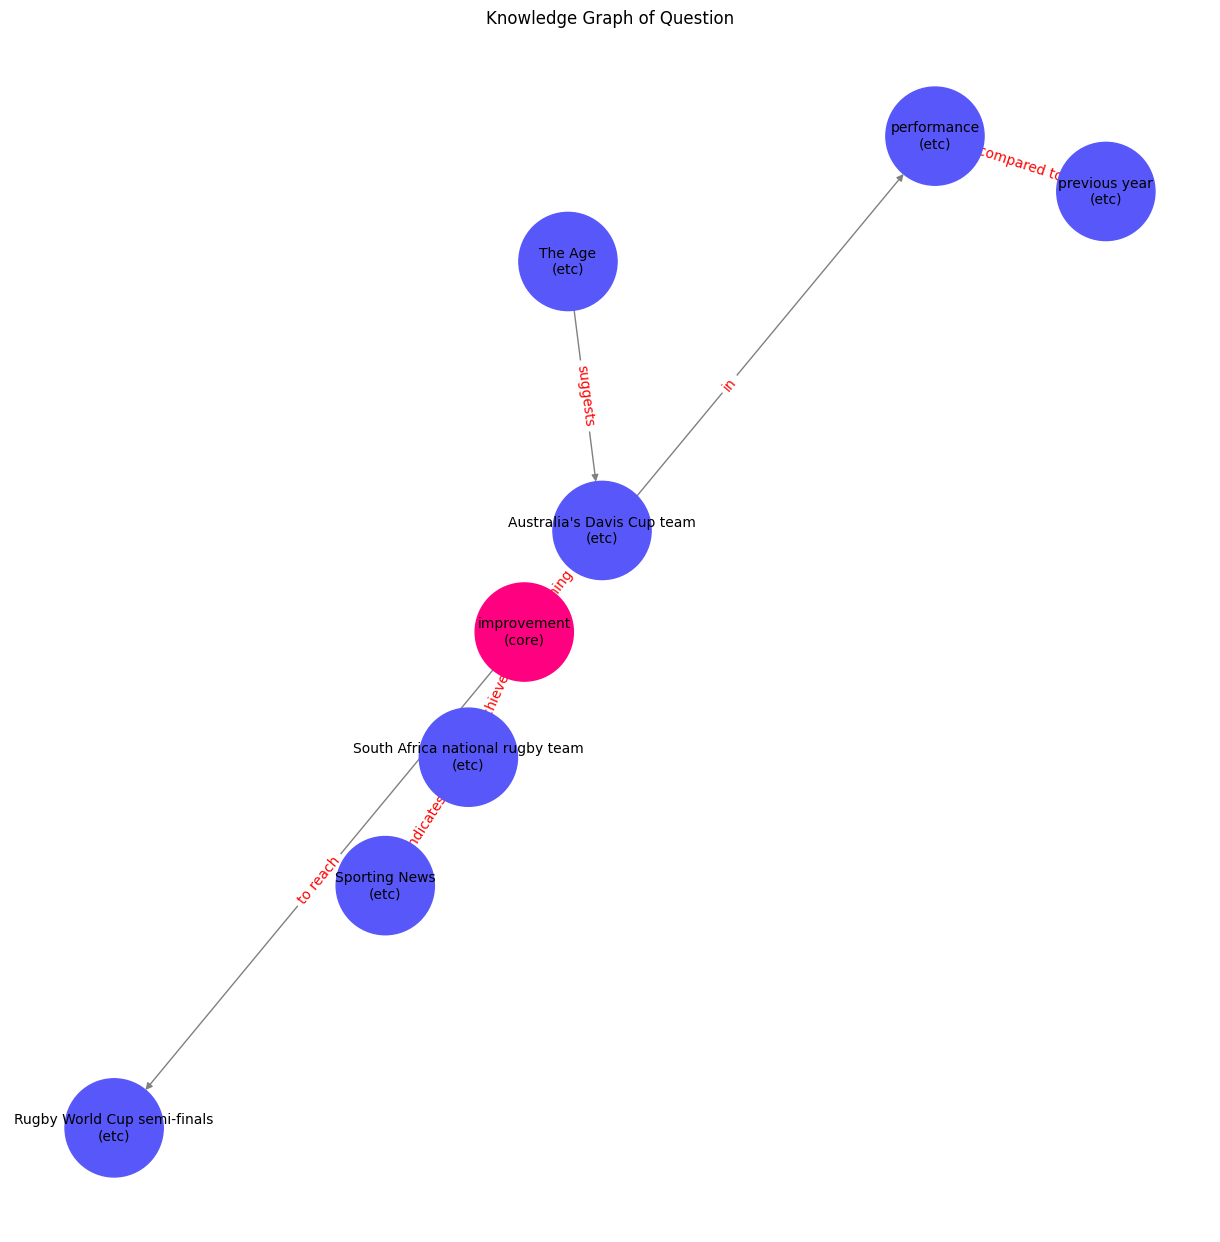

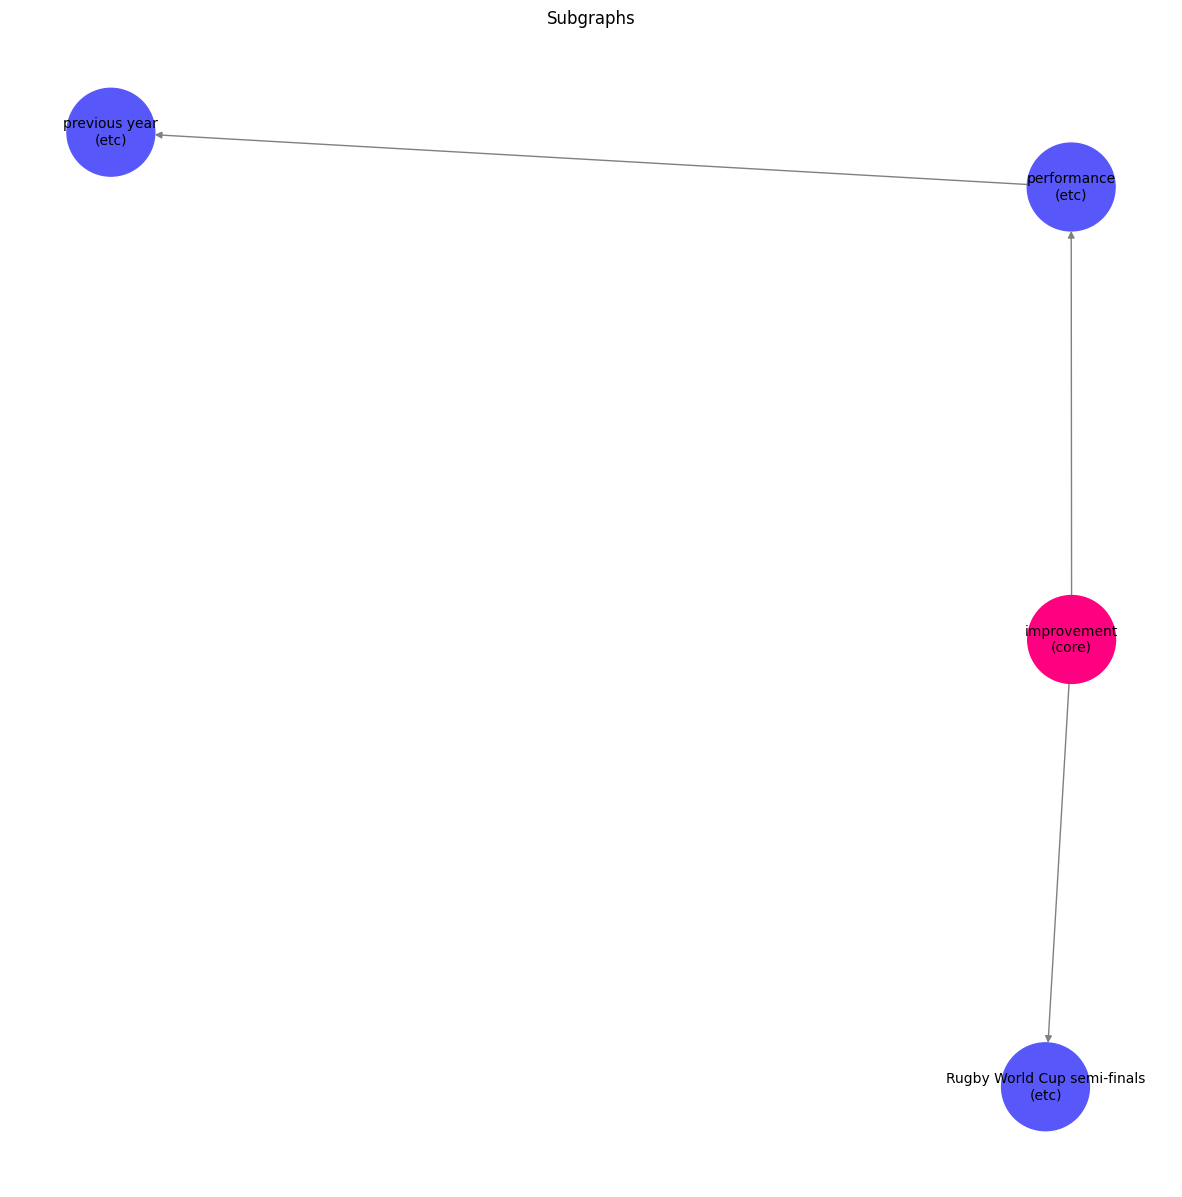

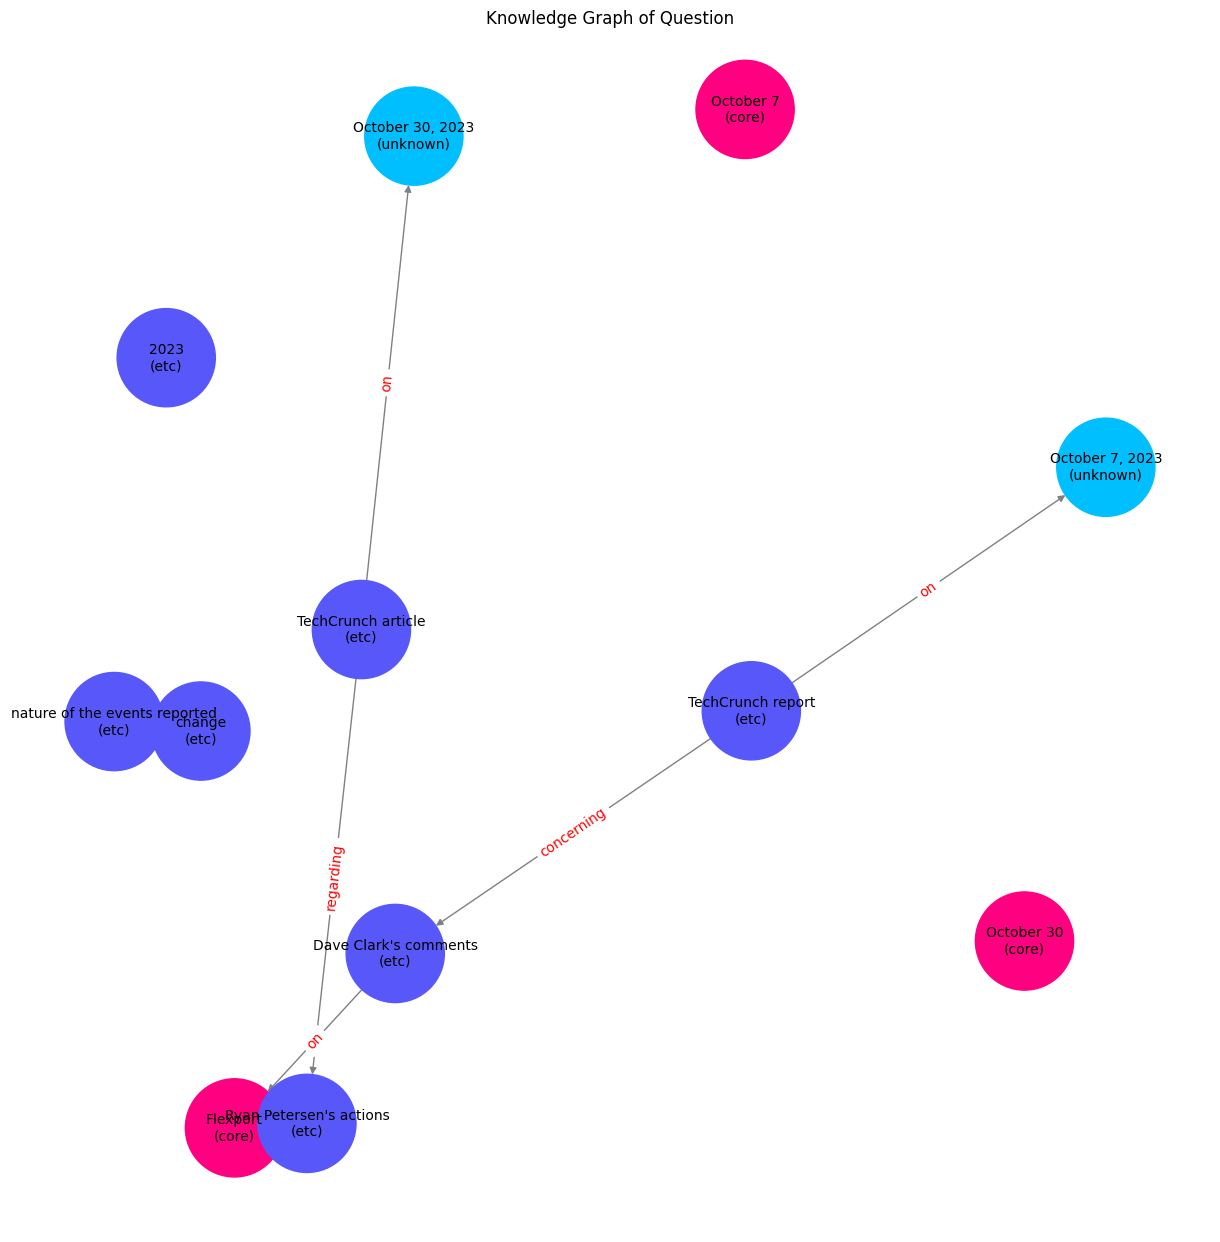

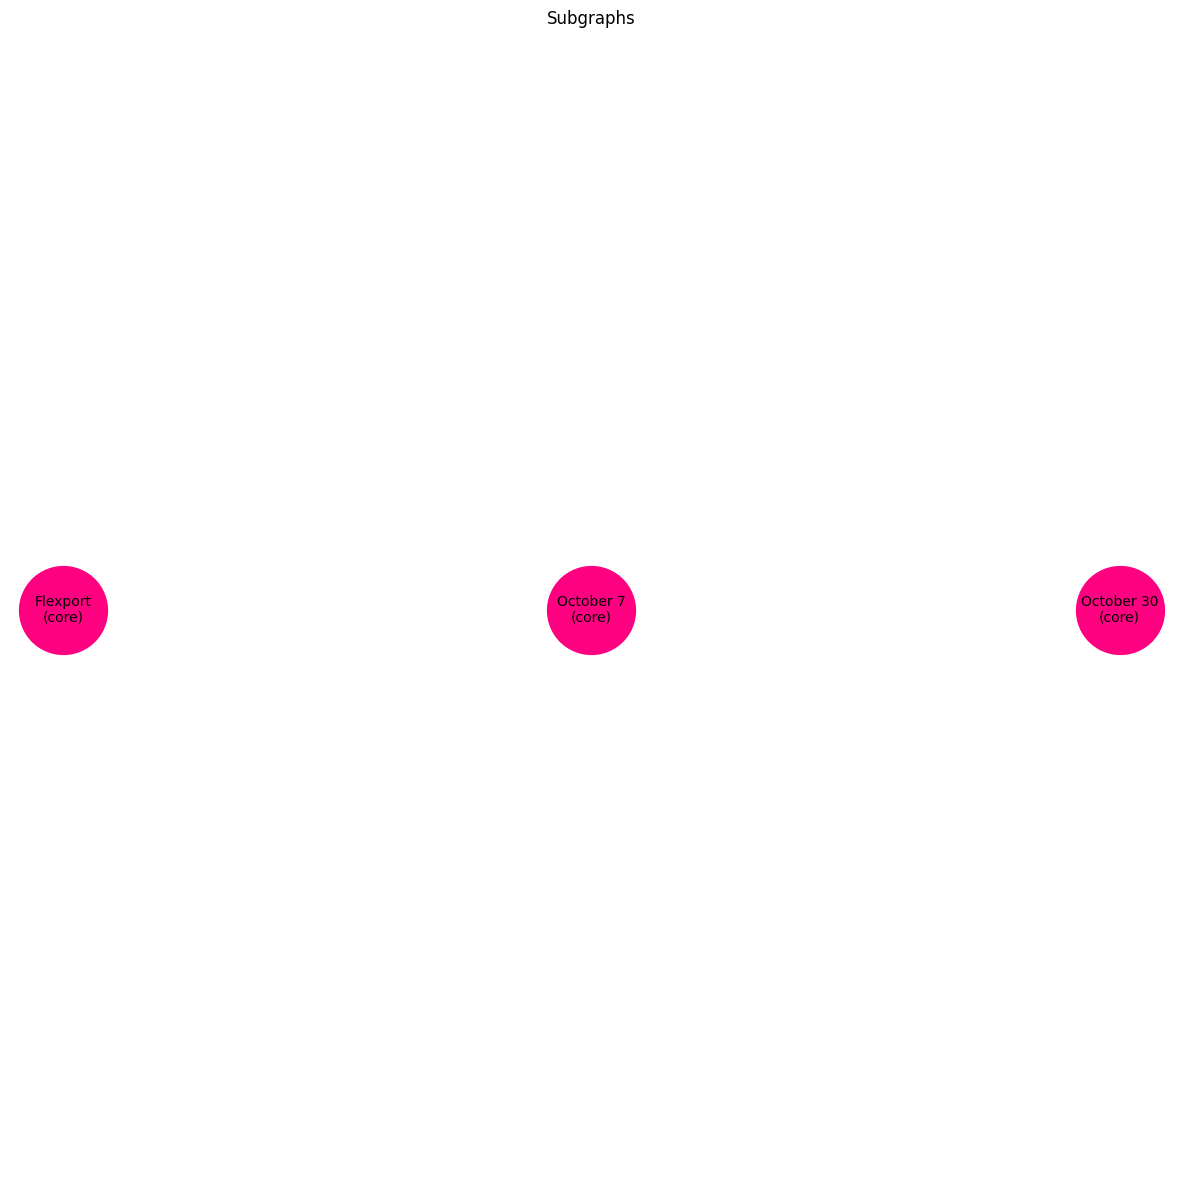

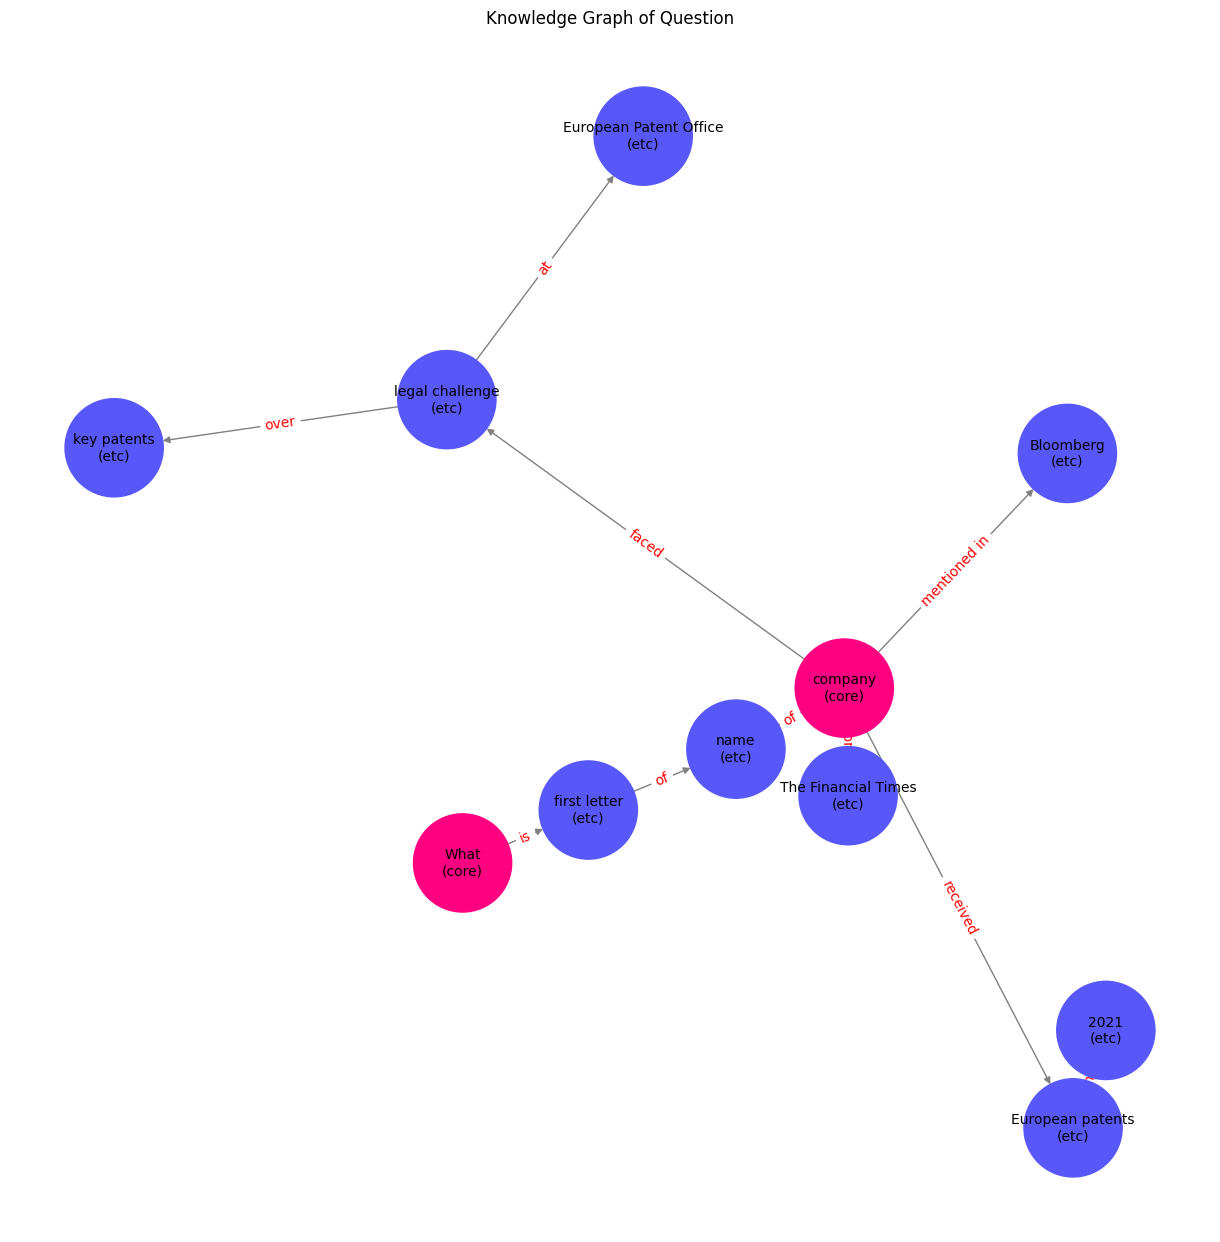

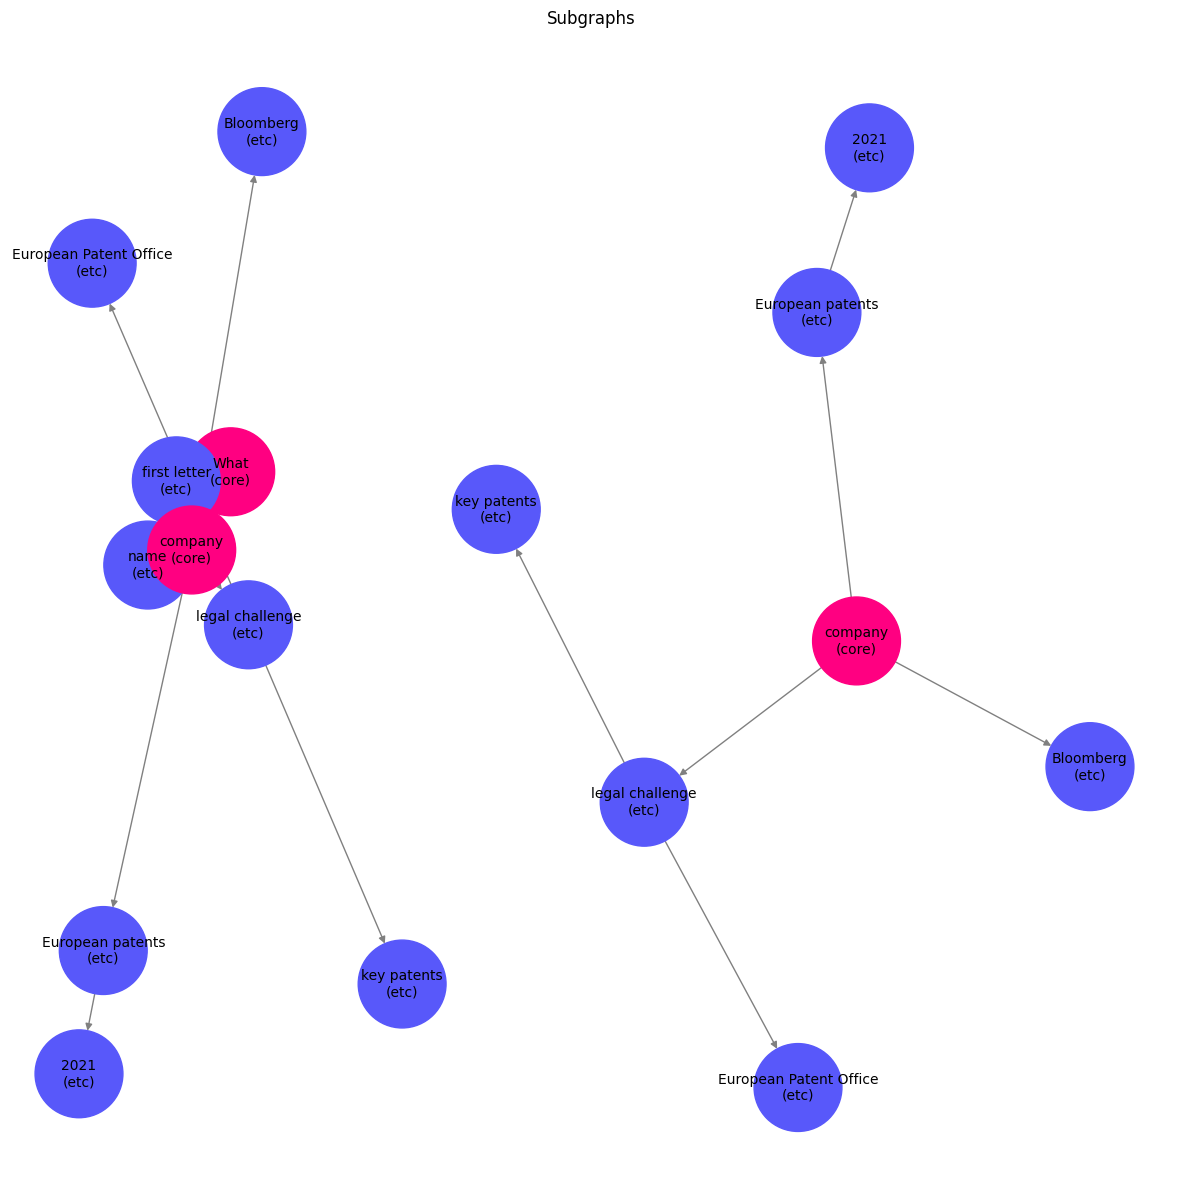

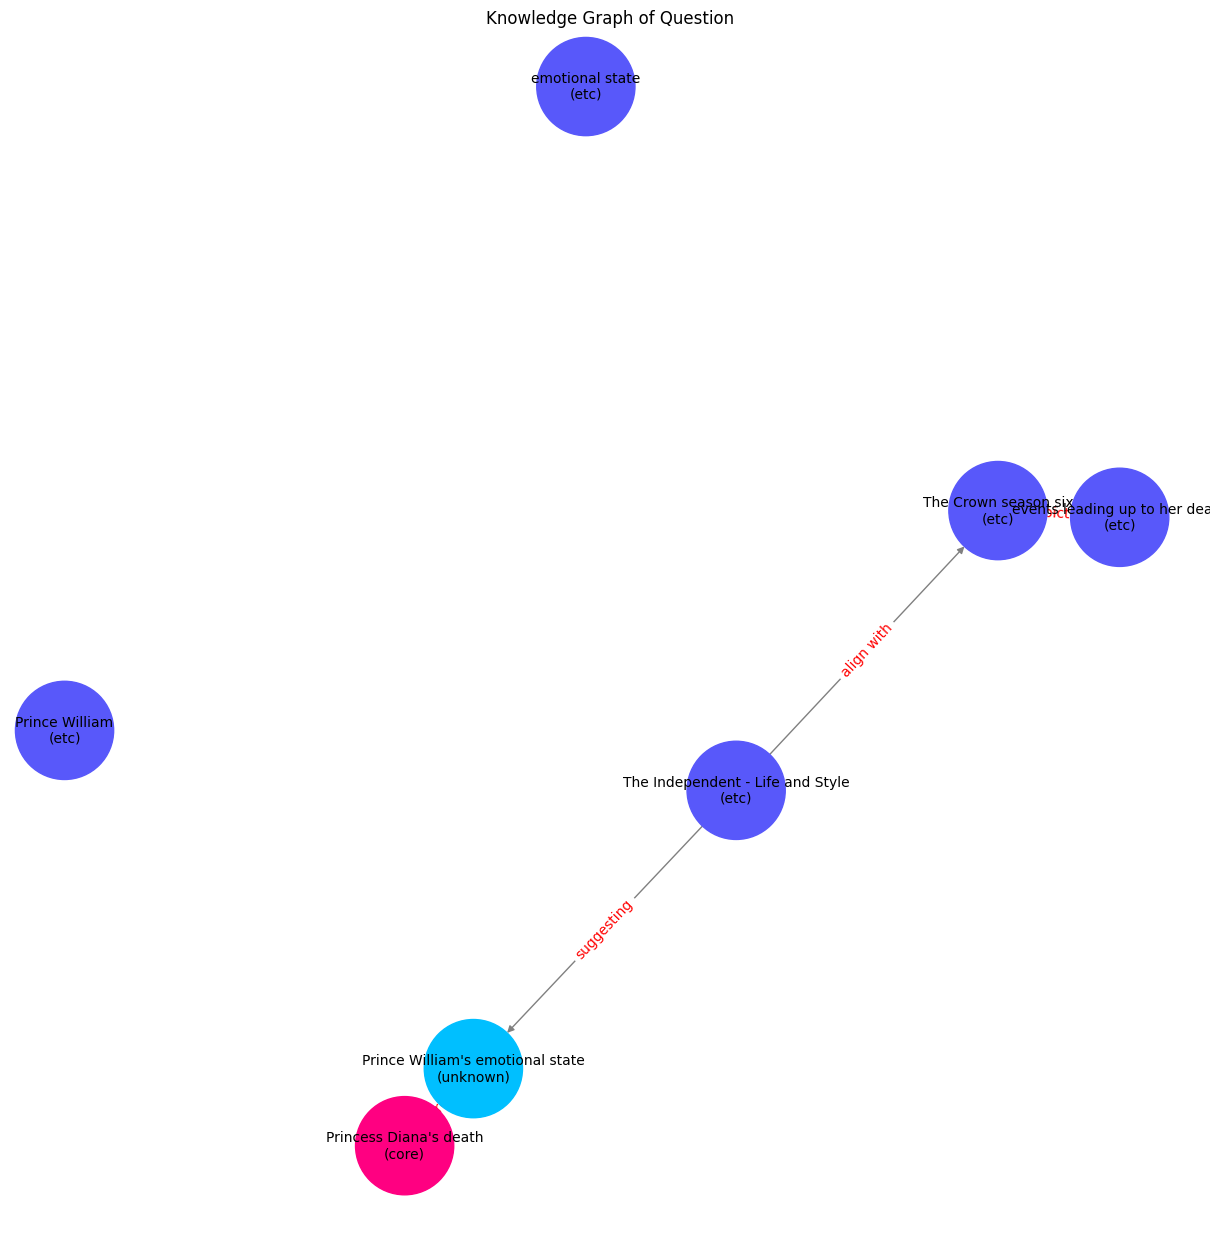

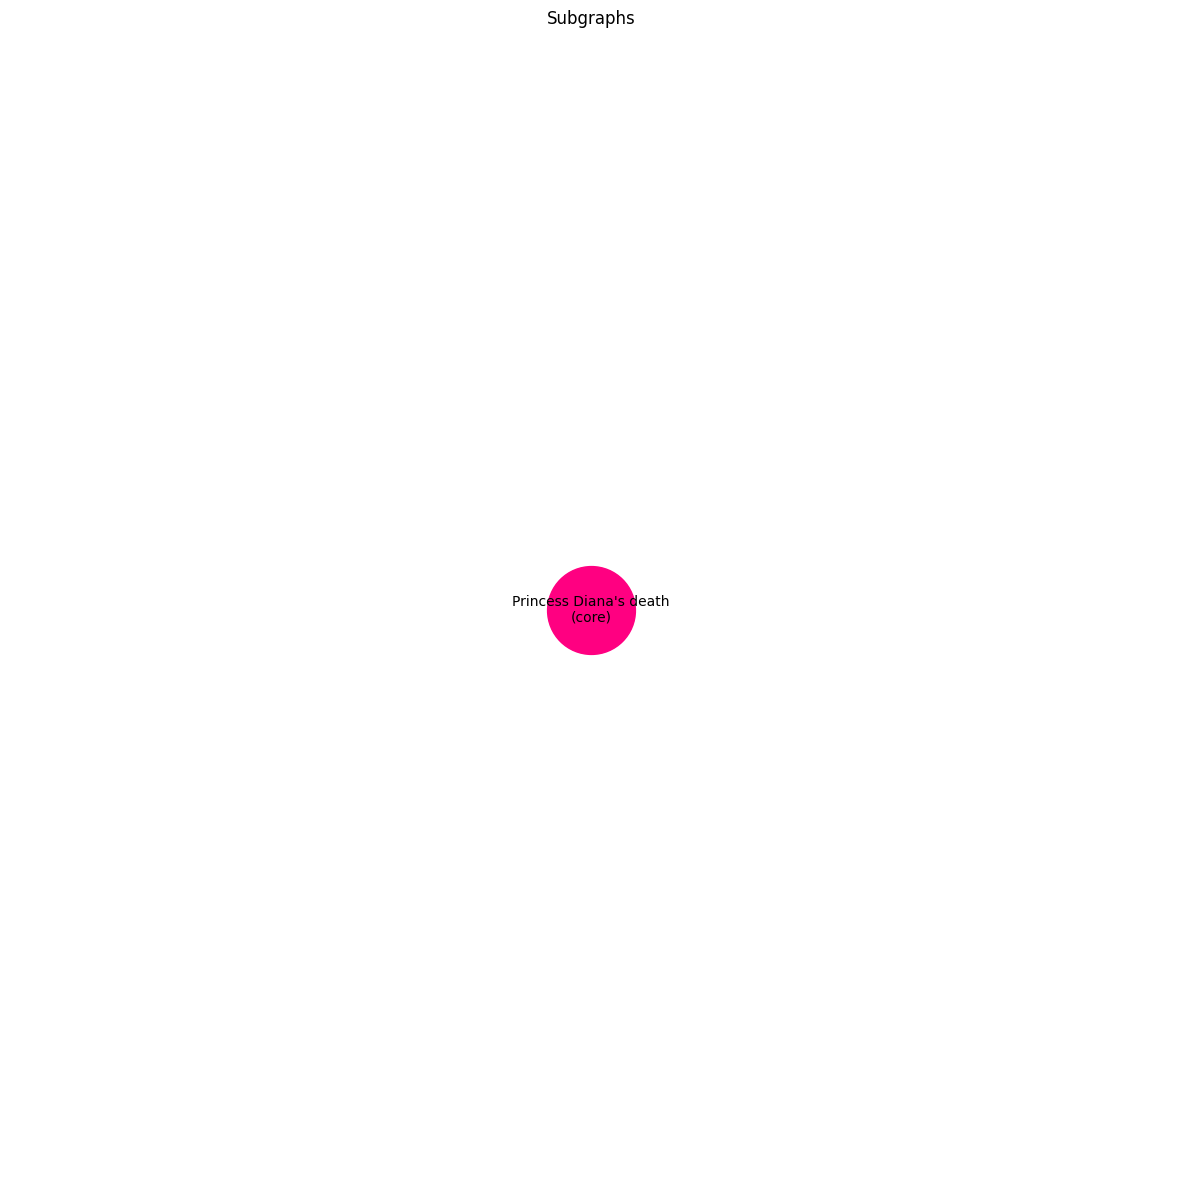

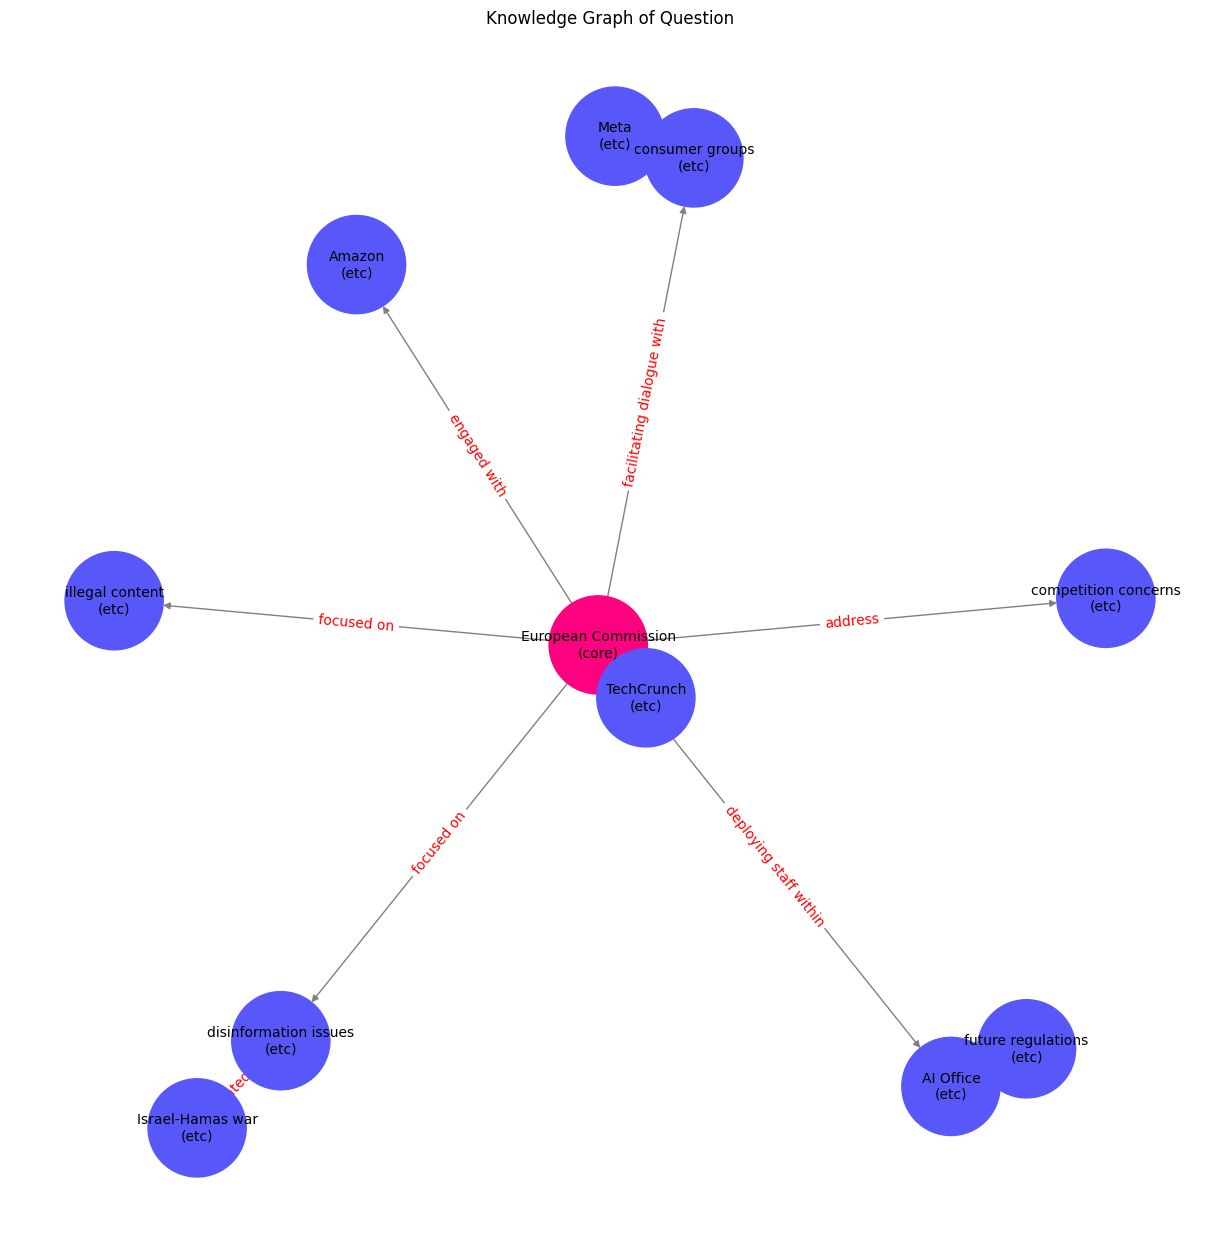

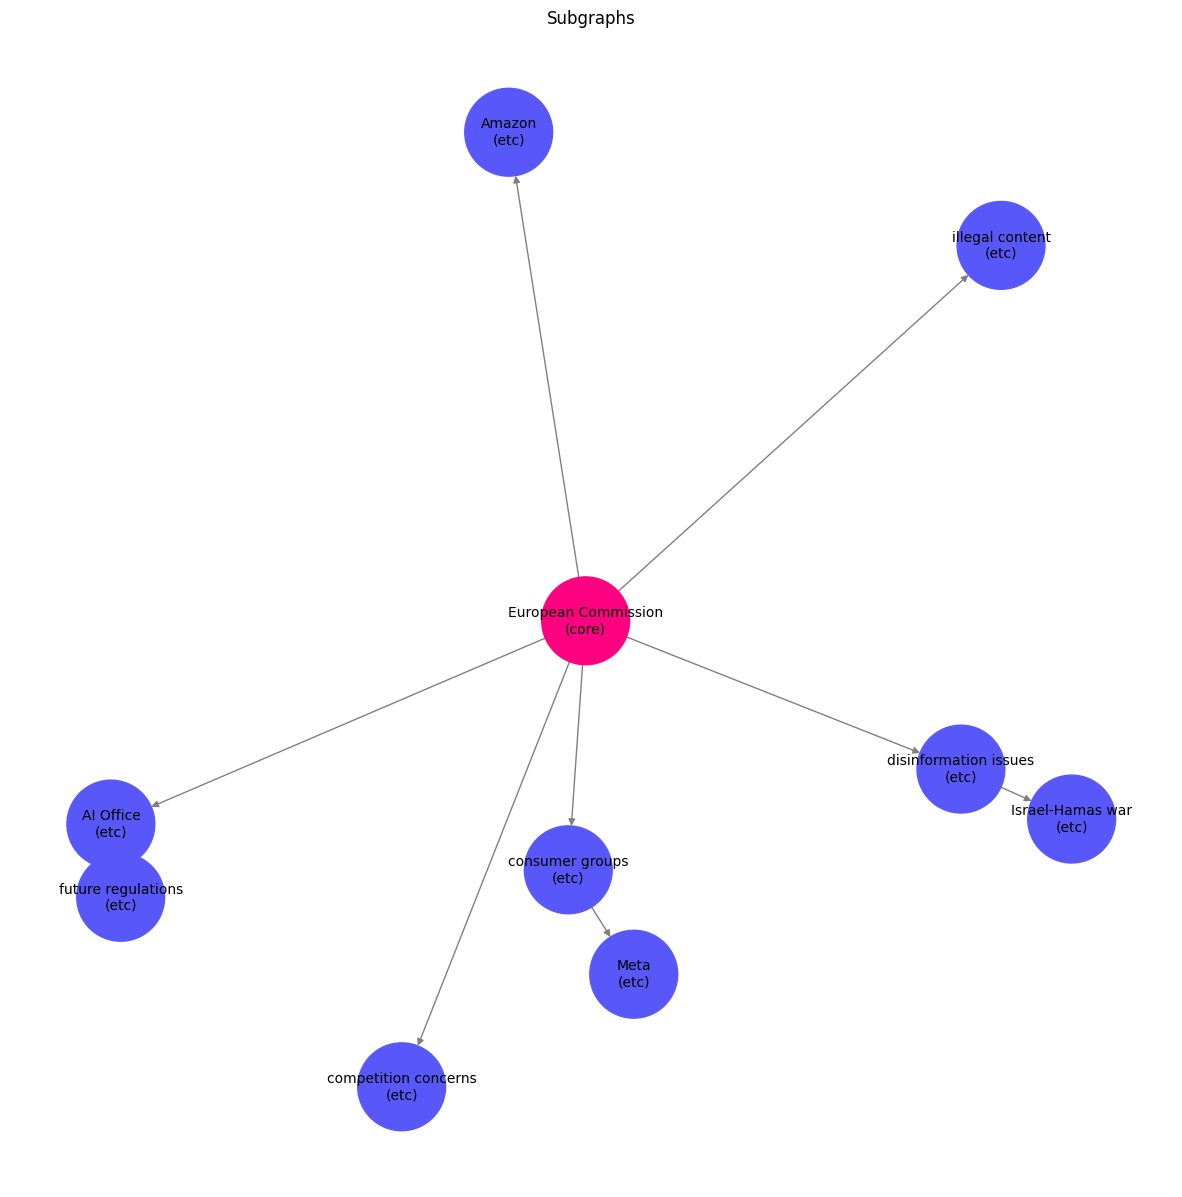

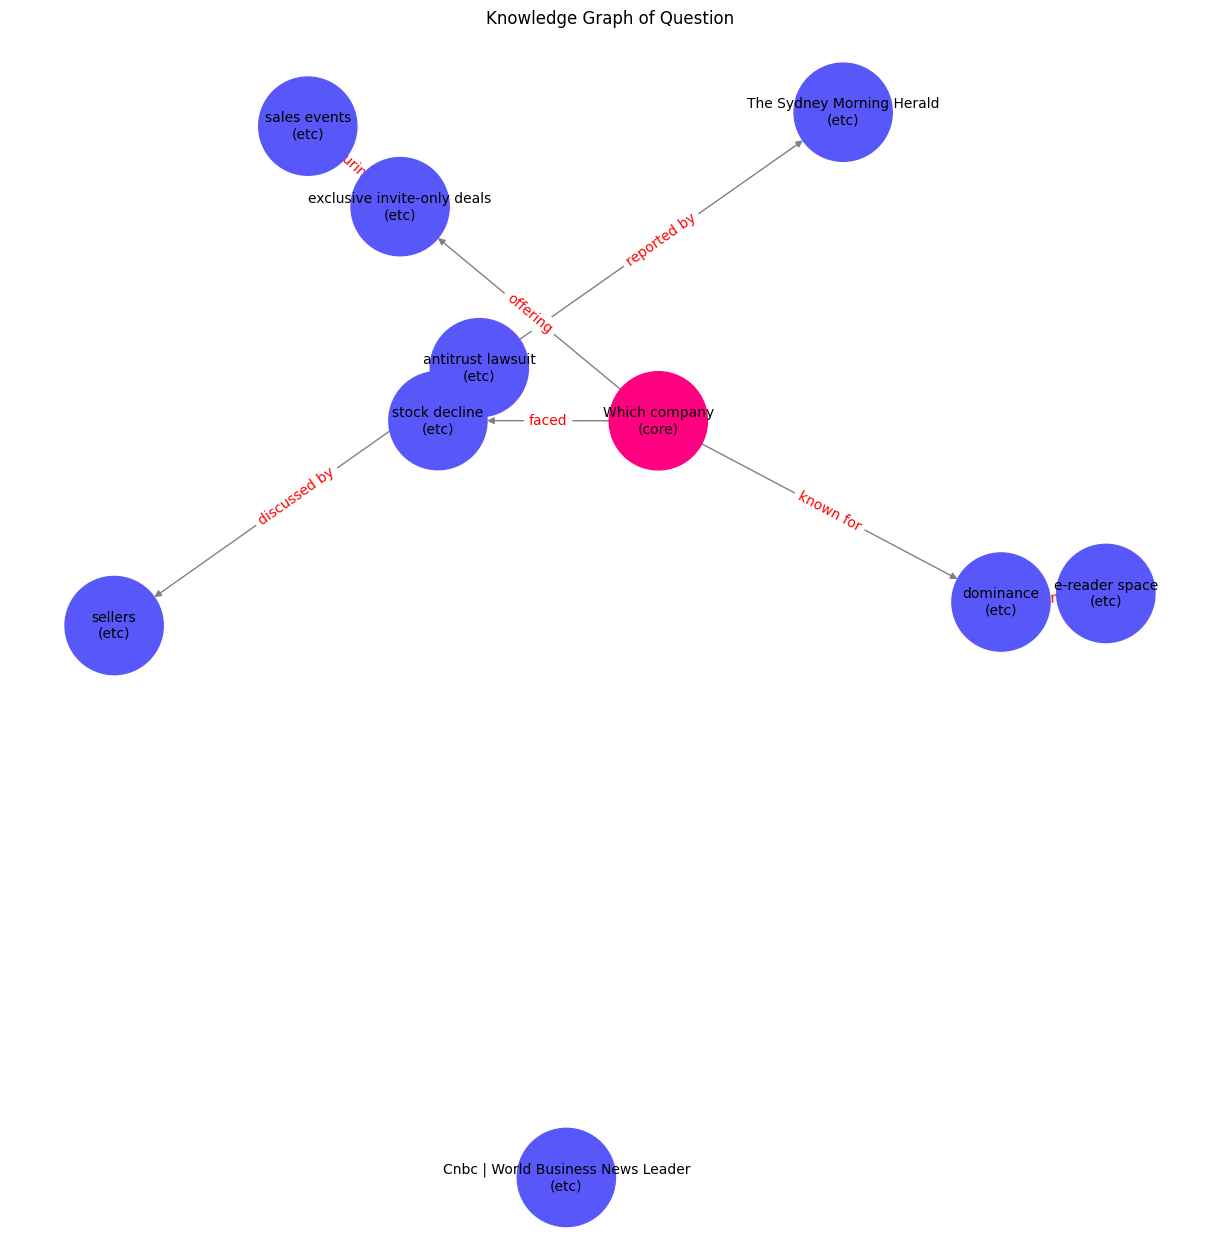

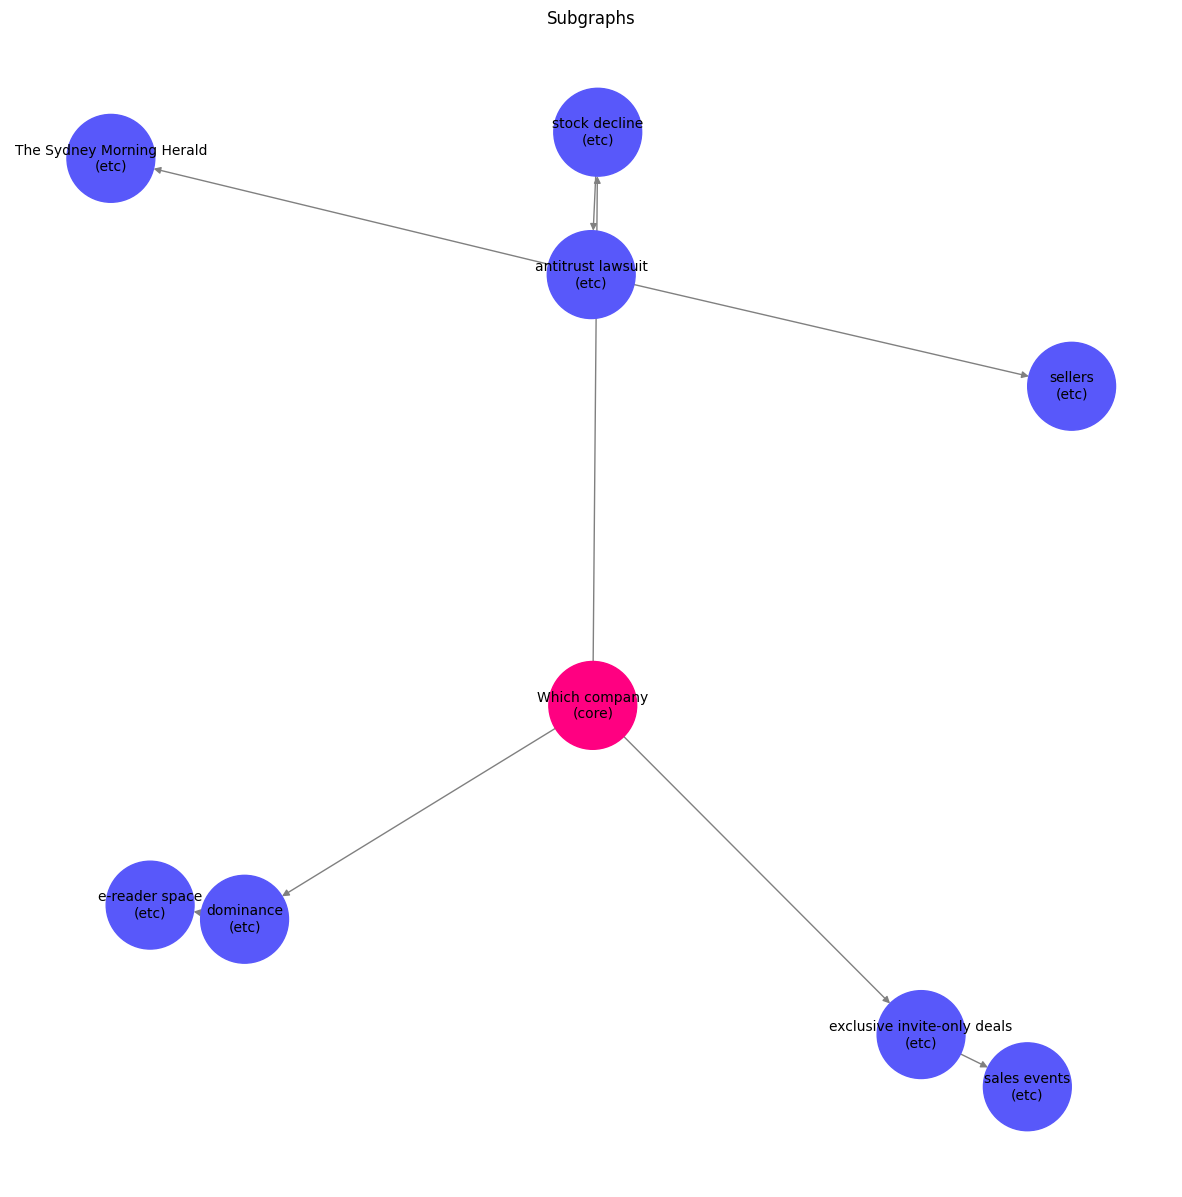

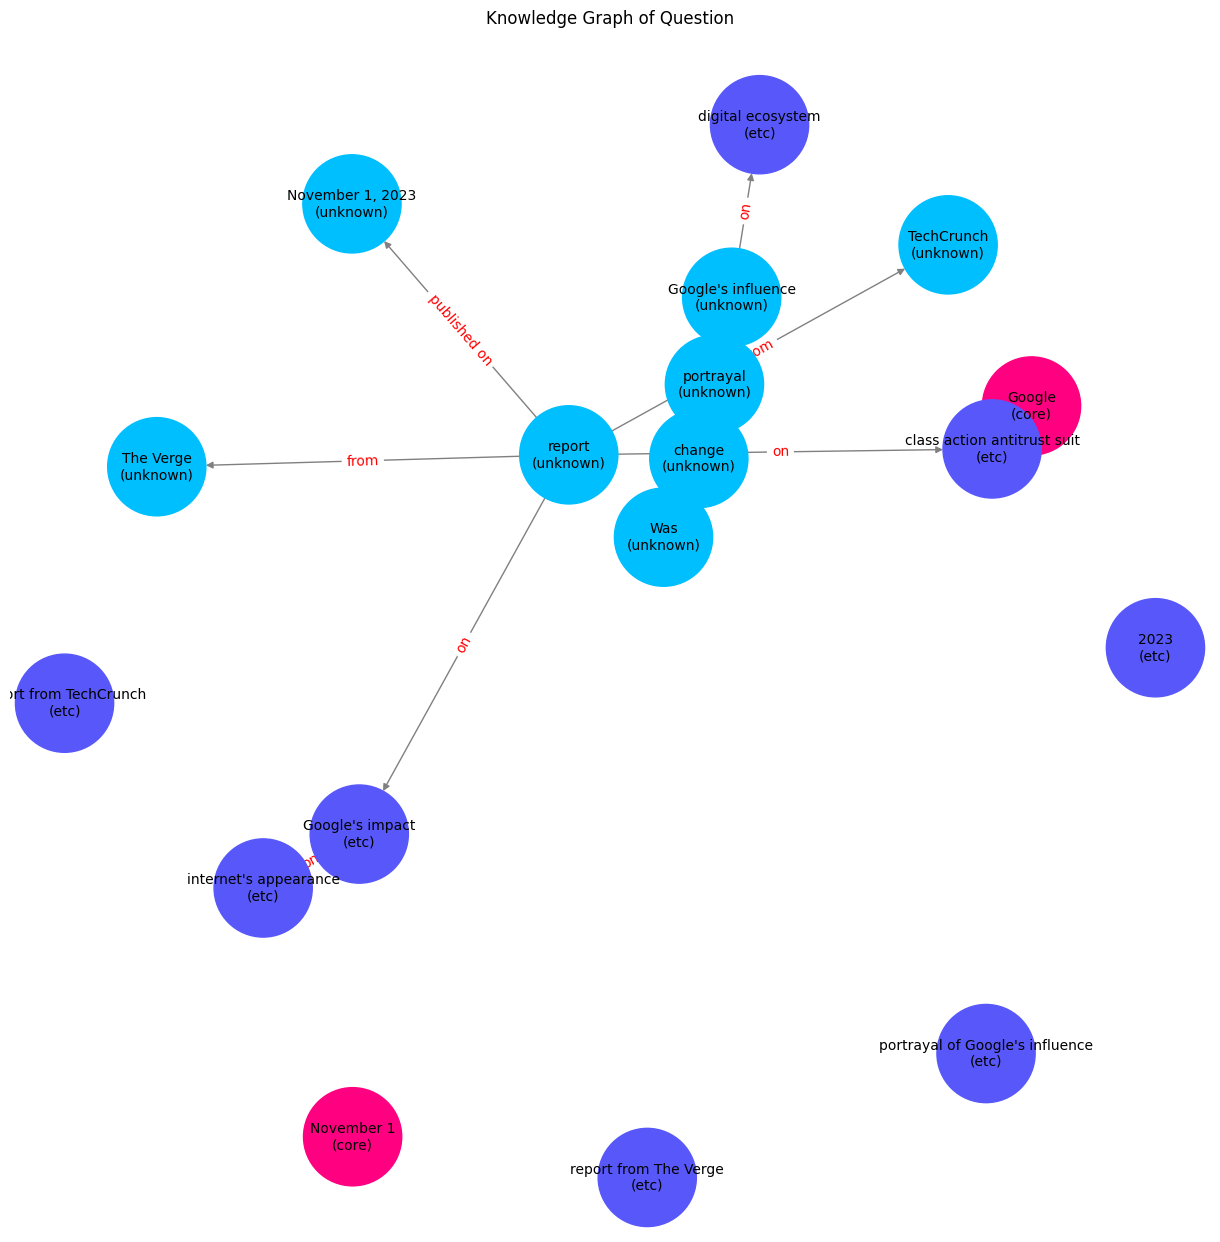

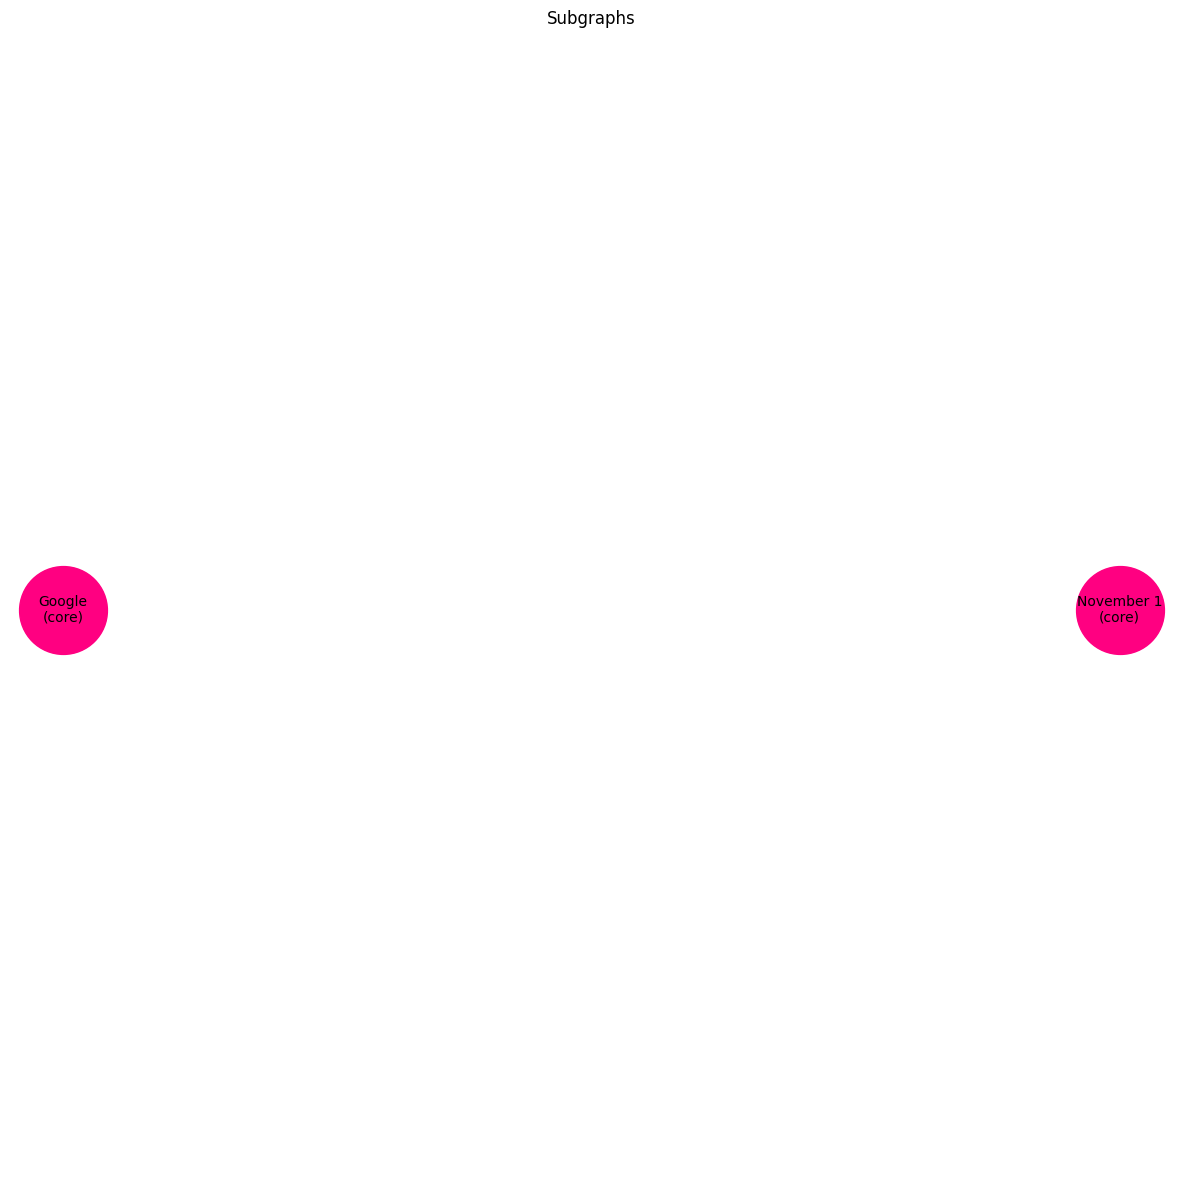

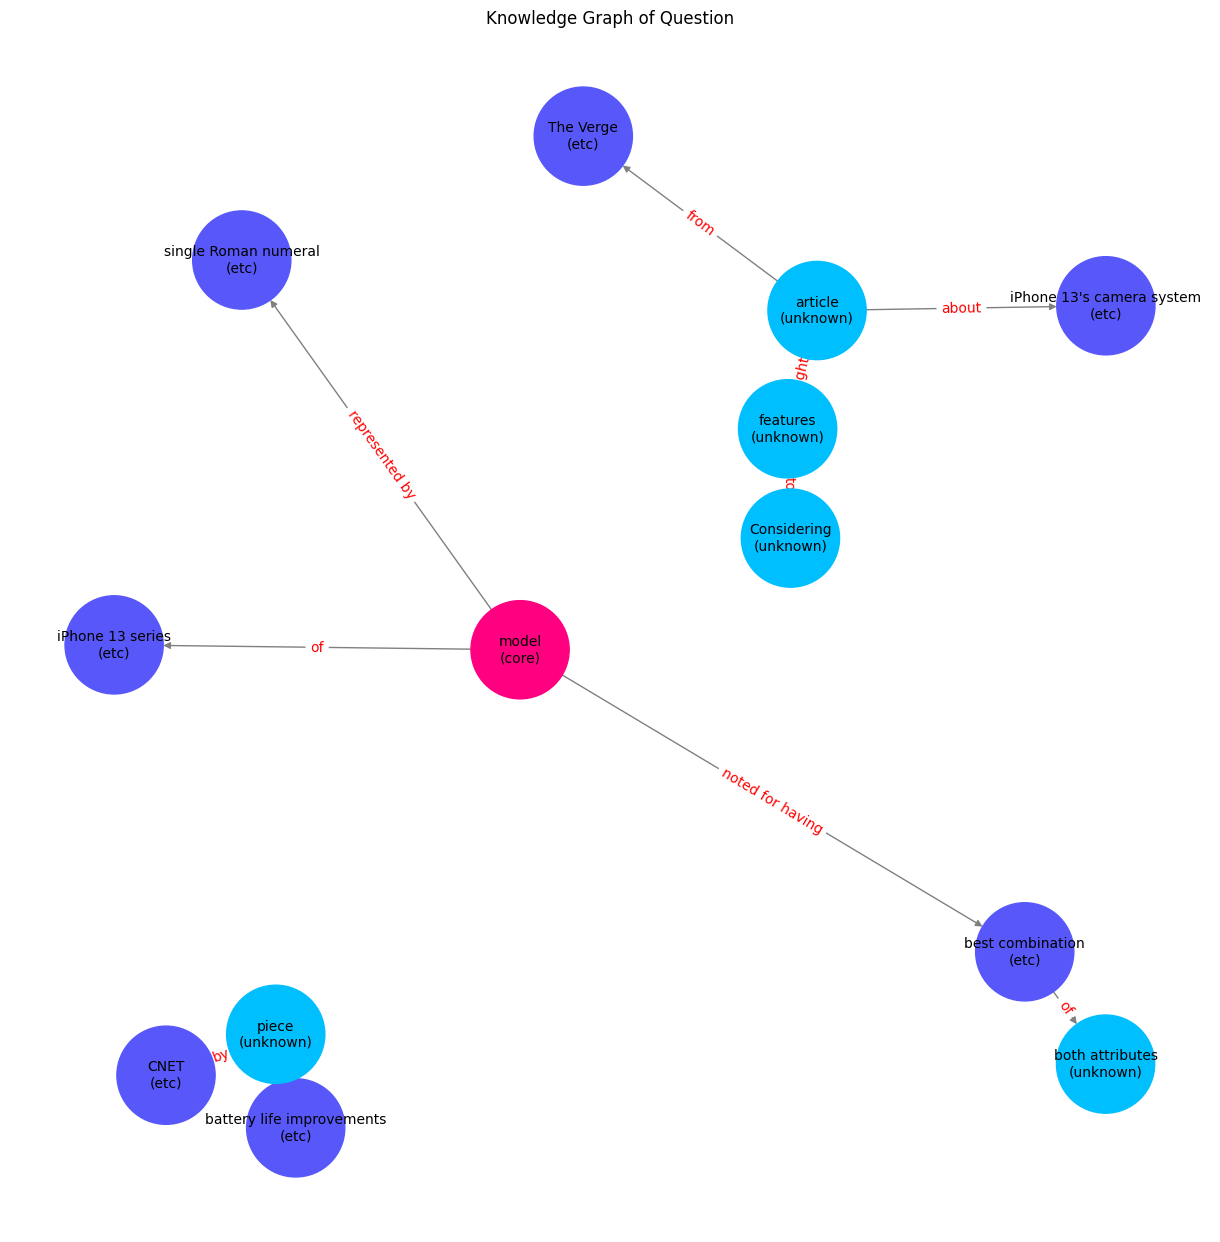

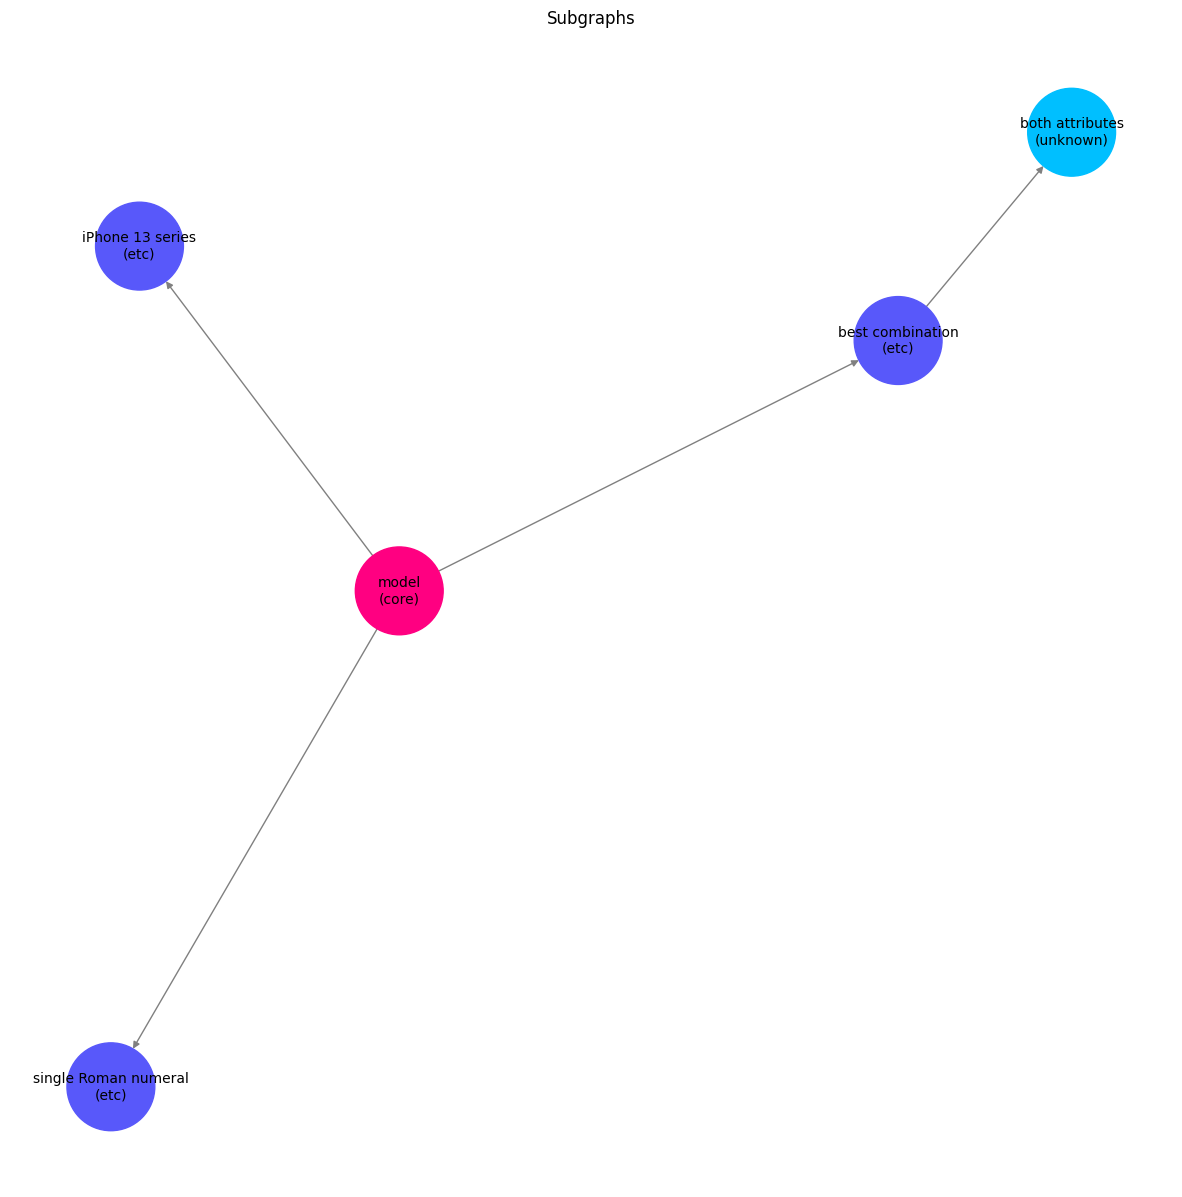

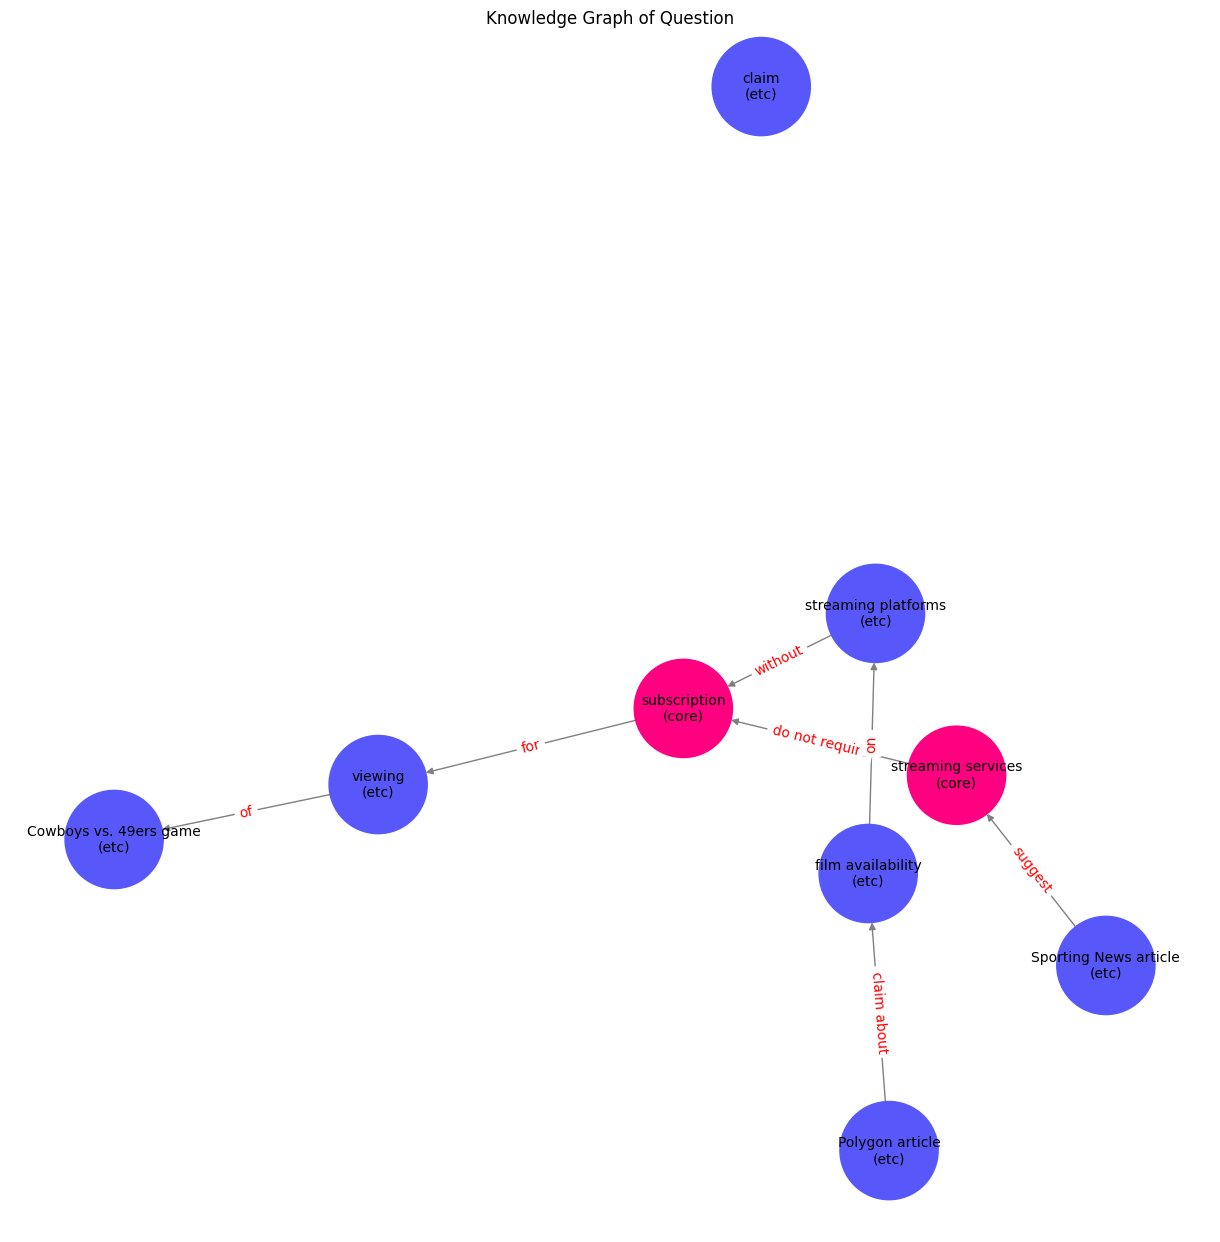

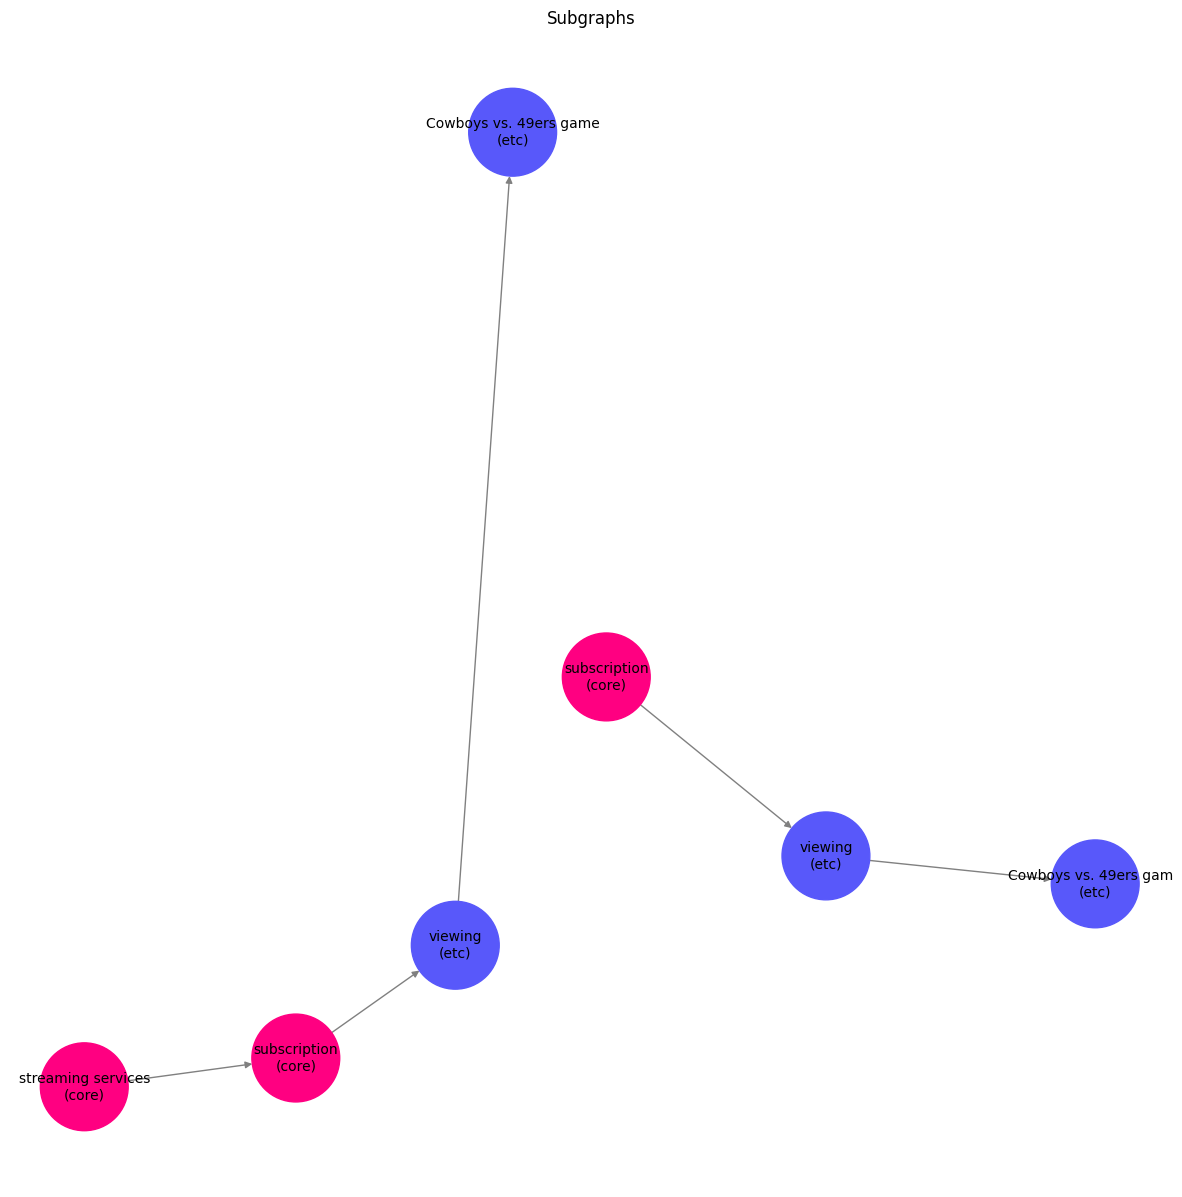

In [ ]:
decom_question = []

for query in questions:
  entities = get_entities(query)
  relations = get_re(entities, query)
  rener_json = convert_rener(entities, relations)

  cores = get_core(entities, relations, query)
  cores_json = convert_core(cores)

    # 방향성 그래프 생성 및 데이터 추가
  G = nx.DiGraph()

  for nodes_with_attribute in cores_json:
    if(nodes_with_attribute['attribute'] == "core"):
      G.add_node(nodes_with_attribute['entity'], type=nodes_with_attribute['attribute'], color="#FF0081")
    elif(nodes_with_attribute['attribute']=="etc"):
      G.add_node(nodes_with_attribute['entity'], type=nodes_with_attribute['attribute'], color="#5858FA")
    else:
      G.add_node(nodes_with_attribute['entity'], type=nodes_with_attribute['attribute'], color="#005DEA")


  for edge in rener_json['relations']:
    G.add_edge(edge['subject'], edge['object'], relation=edge['relation'])

  # Knowledge Graph 시각화
  # 노드 라벨 생성 (노드 이름과 타입 정보 포함)
  labels = {node: f"{node}\n({data.get('type', 'unknown')})" for node, data in G.nodes(data=True)}

  # 전체 그래프 시각화
  plt.figure(figsize=(12, 12))
  pos = nx.spring_layout(G)  # 노드 배치를 위한 레이아웃 설정

  # Node의 색상을 그대로 유지
  node_colors = [data.get('color', '#00BFFF') for node, data in G.nodes(data=True)]

  # Root Node를 [root_nodes]에 저장
  root_nodes = [node for node, in_degree in G.in_degree() if in_degree == 0]
  #print("Root nodes: ", root_nodes)

  nx.draw(G, pos, labels=labels, node_color=node_colors, edge_color='gray', node_size=5000, font_size=10, arrows=True)

  # Edge에 Label내용추가
  edge_labels = nx.get_edge_attributes(G, 'relation')
  nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')


  plt.title('Knowledge Graph of Question')
  #plt.show()

  components = list(nx.weakly_connected_components(G))
  Sep_graph = [G.subgraph(c).copy() for c in components]

  Final_graph = []
  for GRAPH in Sep_graph:
      Final_graph.extend(create_subgraphs_by_type(GRAPH, "core"))

  Final_graph = flatten_list(Final_graph)

  #for i in Final_graph:
  #    print(i.nodes)

  # 플롯 설정
  fig, ax = plt.subplots(figsize=(15, 15))

  # 서브그래프들의 위치 조정을 위한 초기 x 좌표
  x_offset = 0

  # 각 서브그래프를 그리기
  for i, subgraph in enumerate(Final_graph):
      # 노드 라벨 생성 (노드 이름과 타입 정보 포함)
      labels = {node: f"{node}\n({data.get('type', 'unknown')})" for node, data in subgraph.nodes(data=True)}
      # Node의 색상을 그대로 유지하되, 색상이 없는 경우 기본 색상 사용
      node_colors = [data.get('color', '#00BFFF') for node, data in subgraph.nodes(data=True)]

      # 서브그래프의 노드 위치 설정
      pos = nx.spring_layout(subgraph)
      pos = {node: (x + x_offset, y) for node, (x, y) in pos.items()}  # 위치 조정

      # 서브그래프 그리기
      nx.draw(subgraph, pos, ax=ax, labels=labels, with_labels=True, node_size=4000, node_color=node_colors, font_size=10, font_color='black', edge_color='gray')

      # 다음 서브그래프를 위해 x 좌표 이동
      x_offset += 2

  ax.set_title("Subgraphs")
  #plt.show()

  # 모든 서브그래프에서 tripleset 추출
  Final_triplesets = []
  def extract_triplesets(graph):
      triplesets = []
      for u, v, data in graph.edges(data=True):
          subject = u
          predicate = data.get('relation', 'relation')
          obj = v
          triplesets.append((subject, predicate, obj))
      return triplesets

  # triplesets 추출
  for SubGraph in Final_graph:
      Final_triplesets.append(extract_triplesets(SubGraph))

  temp_decom_question = []
  for tr in Final_triplesets:
    print(tr)
    triples_text = ', '.join([f"('{triple[0]}', '{triple[1]}', '{triple[2]}')" for triple in Final_triplesets[0]])

    messages = [
      {"role": "system", "content": graph_to_text},
      {"role": "user", "content": triples_text}
    ]

    output = process_data(messages)
    print('complete sentence')
    print(output)
    temp_decom_question.append(output)
  print('next')
  decom_question.append(temp_decom_question)


In [ ]:
print(decom_question)

[['Who is associated with an individual associated with the cryptocurrency industry, who is facing a criminal trial on fraud charges and conspiracy charges for committing fraud for personal gain.', 'Who is associated with an individual associated with the cryptocurrency industry, who is facing a criminal trial on fraud charges and conspiracy charges for committing fraud for personal gain.'], ["The individual implicated in inflating the value of Manhattan apartment, not yet achieved in New York City's real estate history, and implicated in adjusting apartment's valuation to compensate for loss in another asset's worth."], ['Who is associated with generative AI technology.', 'Who is associated with generative AI technology.'], ['The increase in revenue is related to payment models and subscription models.'], ["Here is the complete sentence:\n\nThe online betting platform provides a welcome bonus of up to $1000 in bonus bets for new customers' first losses and is anticipated to extend the

In [ ]:

answers = []
contexts = []

# Inference
for index, queries in enumerate(decom_question):
  print(index)

  temp_answers = []
  temp_contexts = []

  for query in queries:
    relevant_docs = retriever.get_relevant_documents(query)
    context_for_query = [docs.page_content for docs in relevant_docs]
    temp_contexts.extend(context_for_query)

    temp_question = ''
    if isinstance(temp_contexts, list):
      temp_contexts = " ".join(map(str, temp_contexts))
    if isinstance(questions[index], list):
      temp_question = " ".join(map(str, questions[index]))

    answer = rag_chain.invoke({
        'context': temp_contexts,
        'question': temp_question
    })

    temp_answers.append(answer)

  answers.append(temp_answers)
  contexts.append(temp_contexts)

0


/usr/local/lib/python3.10/dist-packages/langchain_core/_api/deprecation.py:151: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use invoke instead.
  warn_deprecated(


TypeError: expected string or buffer

In [ ]:
# To dict
temp_ground_truths = []

for gt in ground_truths:
  temp_ground_truths.append(str(gt))

ground_truths = temp_ground_truths


data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truths
}

# Convert dict to dataset
dict_dataset = Dataset.from_dict(data)

# 성능 평가

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    context_entity_recall,
    context_recall,
    context_precision,
    answer_correctness,
    answer_similarity,
    answer_relevancy
)

result = evaluate(
    dataset = dict_dataset,
    metrics=[
        context_precision,
        context_recall,
        context_entity_recall,
        answer_correctness,
        answer_similarity,
        answer_relevancy
    ],
)

df = result.to_pandas()
df['evidence_list'] = evidence_list

In [ ]:
df